# Calculate total Arctic sea ice extent: 
  
Katie Brennan  
December 2021  

In [1]:
import sys,os
import xarray as xr
import numpy as np
import scipy as spy
import pickle 

import time as timestamp 
import importlib

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from collections import OrderedDict 

In [3]:
sys.path.append("/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/")
import LIM_utils as lim

import LIM_utils_kb as limkb
import LIM_stats_kb as statskb
import LIM_plot_kb as plotkb
import LIM_building as limbuild

import run_forecast_model_data as rf

In [170]:
import importlib
importlib.reload(limkb)
importlib.reload(statskb)
importlib.reload(limbuild)

<module 'LIM_building' from '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIM_building.py'>

In [163]:
def load_sic_data(var, exp_setup):
    fdic = limkb.build_training_dic(exp_setup['valid_dsource'])

    Ptrunc = {}
    var_dict_gfdl_hist = {}
    ntims = len(exp_setup['lags'])
    print('Validation data: '+exp_setup['valid_dsource'])

    tecut = int(exp_setup['nyears_startvalid']/12)+(exp_setup['nyearsvalid'])

    X_var_gfdl_hist, var_dict_gfdl_hist = limkb.load_data(var, var_dict_gfdl_hist, fdic, 
                                                      remove_climo=exp_setup['remove_climo'], 
                                                      detrend=exp_setup['detrend'], verbose=verbose, 
                                                      tscut=int(exp_setup['nyears_startvalid']/12), 
                                                      tecut=tecut, lat_cutoff=exp_setup['lat_cutoff'][var])
    
    return  X_var_gfdl_hist, var_dict_gfdl_hist, fdic, tecut

In [164]:
def load_sie_data(var, fdic, exp_setup, tecut):
    var_dict_full_og = {}

    X_var_full_og, var_dict_full_og = limkb.load_data(var, var_dict_full_og, fdic, 
                                                      remove_climo=False, 
                                                      detrend=False, verbose=verbose, 
                                                      tscut=int(exp_setup['nyears_startvalid']/12), 
                                                      tecut=tecut, lat_cutoff=exp_setup['lat_cutoff'][var])

    sie = np.where(X_var_full_og>=0.15,100,0)
    ndof = sie.shape[0]
    ntime = sie.shape[1]
    remove_climo = exp_setup['remove_climo']

    #Detrend: 
    x_var_dt = np.zeros((ndof,int(ntime/12),12))
    climo = np.zeros((ndof,12))
    x_var_3d = np.reshape(sie, (ndof,int(ntime/12),12))
    for i in range(12):
        print('Working on month...'+str(i))
        y = x_var_3d[:,:,i]
        if ('goddard' in fdic[var]) & (np.isnan(y).sum()>0):
            print('Found some nans in satellite data, going to fill with previous timestep...')
            inds = np.where(np.isnan(y))
            ind_int = int(inds[1].min()-1)
            fill = np.ones(y.shape)*y[:,ind_int][:,np.newaxis]
            var_nans_mask = np.where(np.isnan(y),np.nan,1)
            Y = np.where(np.isnan(y),fill,y)
        elif np.isnan(y).sum()>0: 
            print('Found with nans (not in satellite), going to fill with zeros...')
            var_nans_mask = np.where(np.isnan(y),np.nan,1)
            Y = np.where(np.isnan(y),0,y)
        else: 
            Y = y
    #                print('Y = '+ str(Y.shape))
        X = np.arange(0,int(ntime/12))
        [var_dt,_,intercept] = statskb.multi_linear_detrend(X,Y,axis=1,atol=False,
                                                            remove_mn=remove_climo)
        if np.isnan(y).sum()>0:
            x_var_dt[:,:,i] = var_dt*var_nans_mask
        else: 
            x_var_dt[:,:,i] = var_dt
        climo[:,i] = intercept

    x_var_anom = np.reshape(x_var_dt,(ndof,ntime))
    sie_anom_gfdl_hist = x_var_anom
    
    return sie_anom_gfdl_hist

In [165]:
def calc_tot_sia_sie(var, fdic, X_var_gfdl_hist, sie_anom_gfdl_hist, var_dict_gfdl_hist):
    full_names, areawt_name, month_names = limbuild.load_full_names()

    areacell_dict_all = {}
    areacell = {}
    areacell_dict = {}
    areacell[var], areacell_dict_all[var] = limkb.load_data(areawt_name[var], areacell_dict, fdic, 
                                                           remove_climo=False, detrend=False, verbose=False, 
                                                           lat_cutoff=exp_setup['lat_cutoff'][var])

    units = areacell_dict_all[var][areawt_name[var]]['units']

    if 'km' in units:
        acell = areacell[var]
    elif 'centi' in units: 
        print('changing cellarea units from '+
              str(areacell_dict_all[var][areawt_name[var]]['units'])+' to km^2')
        acell = areacell[var]*(1e-10)
        units = 'km^2'
    else: 
        print('changing cellarea units from '+
              str(areacell_dict_all[var][areawt_name[var]]['units'])+' to km^2')
        acell = areacell[var]*(1e-6)
        units = 'km^2'

    nlon = int(var_dict_gfdl_hist[var]['var_ndof']/var_dict_gfdl_hist[var]['lat'].shape[0])

    tot_arc_sia_gfdl_hist_1850_2014 = statskb.calc_tot_si_checks(X_var_gfdl_hist,acell,units,
                                                                var_dict_gfdl_hist[var]['lat'],
                                                                nlon,lat_cutoff=0.0)
    tot_arc_sie_gfdl_hist_1850_2014 = statskb.calc_tot_si_checks(sie_anom_gfdl_hist,acell,units,
                                                                var_dict_gfdl_hist[var]['lat'],
                                                                nlon,lat_cutoff=0.0)
    
    return tot_arc_sia_gfdl_hist_1850_2014, tot_arc_sie_gfdl_hist_1850_2014

In [5]:
ntrunc= 50
#nmodes = 15 # number of coupled EOFs for LIM state space (truncated-state space)
#nmodes = 20
nmodes_sic = 50

lat_cutoff_dict = {'tas':40,'psl':40,'zg':40,'tos':40,'sit':40,'sic':40}

limvars = ['tas','psl','zg','tos','sit','sic']
mo='all'

lags = [0,1,2,3,4,5,6,7,8]

train_dsource = 'cesm_lme'
# train_dsource = 'era5'
# valid_dsource = 'era5'
valid_dsource = 'cesm_lme'

tau = 1

exp_setup = {}
exp_setup['limvars'] = ['tas','psl','zg','tos','sit','sic']
exp_setup['lat_cutoff'] = lat_cutoff_dict
exp_setup['Weight']=True
exp_setup['remove_climo'] = True
exp_setup['detrend'] = True
exp_setup['nyr_train'] = None

yrend = 1650
#yrstart = 1056    # validation 1905-2005, 100 years of validation
yrstart = 1081  # validation 1930-2005, 75 years of validation 
#yrstart = 95  # validation 1915-2015, 75 years of validation 

# #LME settings (in sample): 
exp_setup['nyearsvalid'] = 1000
exp_setup['nyearstrain'] = (yrend-850)
exp_setup['nyears_startvalid'] = 1*12
exp_setup['nyearstot'] = 1155

exp_setup['mo'] = mo
if 'all' in str(mo): 
    exp_setup['ind_month_trunc'] = False
else: 
    exp_setup['ind_month_trunc'] = True
exp_setup['tau'] = tau
exp_setup['train_dsource'] = train_dsource
exp_setup['valid_dsource'] = valid_dsource 
exp_setup['sic_separate'] = True
exp_setup['lags'] = lags
exp_setup['Insamp'] = False
exp_setup['step2_trunc'] = False
exp_setup['ntrunc'] = ntrunc 
exp_setup['nmodes_sic'] = nmodes_sic

verbose = True

In [6]:
var = 'sic'

## CESM LME 851-1850: 

In [7]:
fdic = limkb.build_training_dic(exp_setup['valid_dsource'])
    
Ptrunc = {}
var_dict_train = {}
ntims = len(exp_setup['lags'])
print('Validation data: '+exp_setup['valid_dsource'])

tecut = int(exp_setup['nyears_startvalid']/12)+(exp_setup['nyearsvalid'])

X_var_train, var_dict_train = limkb.load_data(var, var_dict_train, fdic, 
                                              remove_climo=exp_setup['remove_climo'], 
                                              detrend=exp_setup['detrend'], verbose=verbose, 
                                              tscut=int(exp_setup['nyears_startvalid']/12), 
                                              tecut=tecut, lat_cutoff=exp_setup['lat_cutoff'][var])

Validation data: cesm_lme
Loading from sic
Loading from aIceData/LME/LIMs/sic_SImon_CESM_LME_nh_002_085001-200512.nc
time dimension: 851 - 1850
latitude cutoff detected: 40
detrending...
Working on month...0
Found with nans (not in satellite), going to fill with zeros...
Working on month...1
Found with nans (not in satellite), going to fill with zeros...
Working on month...2
Found with nans (not in satellite), going to fill with zeros...
Working on month...3
Found with nans (not in satellite), going to fill with zeros...
Working on month...4
Found with nans (not in satellite), going to fill with zeros...
Working on month...5
Found with nans (not in satellite), going to fill with zeros...
Working on month...6
Found with nans (not in satellite), going to fill with zeros...
Working on month...7
Found with nans (not in satellite), going to fill with zeros...
Working on month...8
Found with nans (not in satellite), going to fill with zeros...
Working on month...9
Found with nans (not in sat

In [8]:
var_dict_full_og = {}

X_var_full_og, var_dict_full_og = limkb.load_data(var, var_dict_full_og, fdic, 
                                                  remove_climo=False, 
                                                  detrend=False, verbose=verbose, 
                                                  tscut=int(exp_setup['nyears_startvalid']/12), 
                                                  tecut=tecut, lat_cutoff=exp_setup['lat_cutoff'][var])

sie = np.where(X_var_full_og>=0.15,100,0)
ndof = sie.shape[0]
ntime = sie.shape[1]
remove_climo = exp_setup['remove_climo']

#Detrend: 
x_var_dt = np.zeros((ndof,int(ntime/12),12))
climo = np.zeros((ndof,12))
x_var_3d = np.reshape(sie, (ndof,int(ntime/12),12))
for i in range(12):
    print('Working on month...'+str(i))
    y = x_var_3d[:,:,i]
    if ('goddard' in fdic[var]) & (np.isnan(y).sum()>0):
        print('Found some nans in satellite data, going to fill with previous timestep...')
        inds = np.where(np.isnan(y))
        ind_int = int(inds[1].min()-1)
        fill = np.ones(y.shape)*y[:,ind_int][:,np.newaxis]
        var_nans_mask = np.where(np.isnan(y),np.nan,1)
        Y = np.where(np.isnan(y),fill,y)
    elif np.isnan(y).sum()>0: 
        print('Found with nans (not in satellite), going to fill with zeros...')
        var_nans_mask = np.where(np.isnan(y),np.nan,1)
        Y = np.where(np.isnan(y),0,y)
    else: 
        Y = y
#                print('Y = '+ str(Y.shape))
    X = np.arange(0,int(ntime/12))
    [var_dt,_,intercept] = statskb.multi_linear_detrend(X,Y,axis=1,atol=False,
                                                        remove_mn=remove_climo)
    if np.isnan(y).sum()>0:
        x_var_dt[:,:,i] = var_dt*var_nans_mask
    else: 
        x_var_dt[:,:,i] = var_dt
    climo[:,i] = intercept

x_var_anom = np.reshape(x_var_dt,(ndof,ntime))
sie_anom_train = x_var_anom

Loading from sic
Loading from aIceData/LME/LIMs/sic_SImon_CESM_LME_nh_002_085001-200512.nc
time dimension: 851 - 1850
latitude cutoff detected: 40
-----------------------------------------------------
completed in 5.089312314987183 seconds
-----------------------------------------------------
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11


In [9]:
full_names, areawt_name, month_names = limbuild.load_full_names()

areacell_dict_all = {}
areacell = {}
areacell_dict = {}
areacell[var], areacell_dict_all[var] = limkb.load_data(areawt_name[var], areacell_dict, fdic, 
                                                       remove_climo=False, detrend=False, verbose=False, 
                                                       lat_cutoff=exp_setup['lat_cutoff'][var])

Loading from b22/Documents/SeaIceData/LME/LIMs/areacello_global_LME_02.nc
latitude cutoff detected: 40


In [10]:
units = areacell_dict_all[var][areawt_name[var]]['units']

if 'km' in units:
    acell = areacell[var]
elif 'centi' in units: 
    print('changing cellarea units from '+
          str(areacell_dict_all[var][areawt_name[var]]['units'])+' to km^2')
    acell = areacell[var]*(1e-10)
    units = 'km^2'
else: 
    print('changing cellarea units from '+
          str(areacell_dict_all[var][areawt_name[var]]['units'])+' to km^2')
    acell = areacell[var]*(1e-6)
    units = 'km^2'

changing cellarea units from centimeter^2 to km^2


In [11]:
nlon = int(var_dict_train[var]['var_ndof']/var_dict_train[var]['lat'].shape[0])

tot_arc_sia_lme_851_1850 = statskb.calc_tot_si_checks(X_var_train,acell,units,
                                                      var_dict_train[var]['lat'],nlon,lat_cutoff=0.0)
tot_arc_sie_lme_851_1850 = statskb.calc_tot_si_checks(sie_anom_train,acell,units,
                                                      var_dict_train[var]['lat'],nlon,lat_cutoff=0.0)

Max concentration is 97.9 ...dividing concentration by 100.
Max concentration is 100.0 ...dividing concentration by 100.


Text(0.5, 1.0, 'CESM LME (851-1850)')

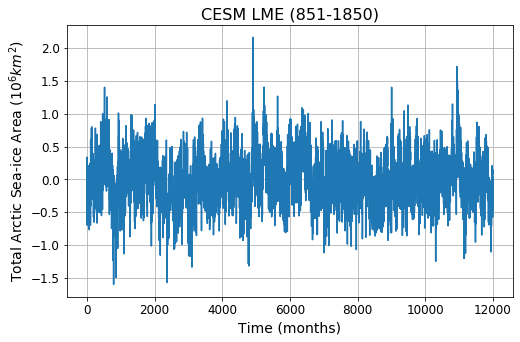

In [12]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(tot_arc_sia_lme_851_1850/1e6)

plt.xlabel('Time (months)', fontsize=14)
plt.ylabel('Total Arctic Sea-ice Area ($10^6 km^2$)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title('CESM LME (851-1850)', fontsize=16)

Text(0.5, 1.0, 'CESM LME (851-1850)')

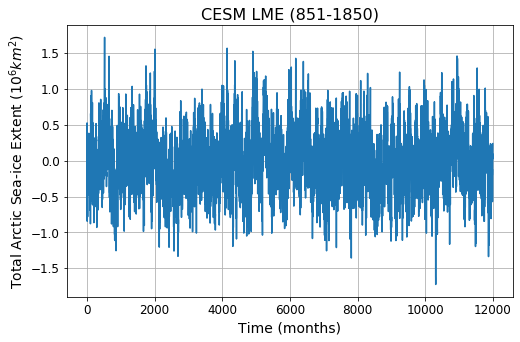

In [13]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(tot_arc_sie_lme_851_1850/1e6)

plt.xlabel('Time (months)', fontsize=14)
plt.ylabel('Total Arctic Sea-ice Extent ($10^6 km^2$)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title('CESM LME (851-1850)', fontsize=16)

### Load tos lat/lon data: 

In [14]:
fdic = limkb.build_training_dic(exp_setup['valid_dsource'])
    
Ptrunc = {}
var_dict_train_tos = {}
ntims = len(exp_setup['lags'])
print('Validation data: '+exp_setup['valid_dsource'])

tecut = int(exp_setup['nyears_startvalid']/12)+(exp_setup['nyearsvalid'])

_, var_dict_train_tos = limkb.load_data('tos', var_dict_train, fdic, 
                                      remove_climo=exp_setup['remove_climo'], 
                                      detrend=exp_setup['detrend'], verbose=verbose, 
                                      tscut=int(exp_setup['nyears_startvalid']/12), 
                                      tecut=tecut, lat_cutoff=exp_setup['lat_cutoff'][var])

Validation data: cesm_lme
Loading from tos
Loading from a/LME/LIMs/tos_sfc_Omon_CESM_LMEallforc_002_085001-200512.nc
time dimension: 851 - 1850
latitude cutoff detected: 40
detrending...
Working on month...0
Found with nans (not in satellite), going to fill with zeros...
Working on month...1
Found with nans (not in satellite), going to fill with zeros...
Working on month...2
Found with nans (not in satellite), going to fill with zeros...
Working on month...3
Found with nans (not in satellite), going to fill with zeros...
Working on month...4
Found with nans (not in satellite), going to fill with zeros...
Working on month...5
Found with nans (not in satellite), going to fill with zeros...
Working on month...6
Found with nans (not in satellite), going to fill with zeros...
Working on month...7
Found with nans (not in satellite), going to fill with zeros...
Working on month...8
Found with nans (not in satellite), going to fill with zeros...
Working on month...9
Found with nans (not in sat

## CESM LME 1851-2005: 

In [15]:
exp_setup['nyearsvalid'] =155
exp_setup['nyearstrain'] = (yrend-850)
exp_setup['nyearstot'] = 1155
exp_setup['nyears_startvalid'] = 1001*12

In [16]:
fdic = limkb.build_training_dic(exp_setup['valid_dsource'])
    
Ptrunc = {}
var_dict_lme_hist = {}
ntims = len(exp_setup['lags'])
print('Validation data: '+exp_setup['valid_dsource'])

tecut = int(exp_setup['nyears_startvalid']/12)+(exp_setup['nyearsvalid'])

X_var_lme_hist, var_dict_lme_hist = limkb.load_data(var, var_dict_lme_hist, fdic, 
                                                  remove_climo=exp_setup['remove_climo'], 
                                                  detrend=exp_setup['detrend'], verbose=verbose, 
                                                  tscut=int(exp_setup['nyears_startvalid']/12), 
                                                  tecut=tecut, lat_cutoff=exp_setup['lat_cutoff'][var])

Validation data: cesm_lme
Loading from sic
Loading from aIceData/LME/LIMs/sic_SImon_CESM_LME_nh_002_085001-200512.nc
time dimension: 1851 - 2005
latitude cutoff detected: 40
detrending...
Working on month...0
Found with nans (not in satellite), going to fill with zeros...
Working on month...1
Found with nans (not in satellite), going to fill with zeros...
Working on month...2
Found with nans (not in satellite), going to fill with zeros...
Working on month...3
Found with nans (not in satellite), going to fill with zeros...
Working on month...4
Found with nans (not in satellite), going to fill with zeros...
Working on month...5
Found with nans (not in satellite), going to fill with zeros...
Working on month...6
Found with nans (not in satellite), going to fill with zeros...
Working on month...7
Found with nans (not in satellite), going to fill with zeros...
Working on month...8
Found with nans (not in satellite), going to fill with zeros...
Working on month...9
Found with nans (not in sa

In [17]:
var_dict_full_og = {}

X_var_full_og, var_dict_full_og = limkb.load_data(var, var_dict_full_og, fdic, 
                                                  remove_climo=False, 
                                                  detrend=False, verbose=verbose, 
                                                  tscut=int(exp_setup['nyears_startvalid']/12), 
                                                  tecut=tecut, lat_cutoff=exp_setup['lat_cutoff'][var])

sie = np.where(X_var_full_og>=0.15,100,0)
ndof = sie.shape[0]
ntime = sie.shape[1]
remove_climo = exp_setup['remove_climo']

#Detrend: 
x_var_dt = np.zeros((ndof,int(ntime/12),12))
climo = np.zeros((ndof,12))
x_var_3d = np.reshape(sie, (ndof,int(ntime/12),12))
for i in range(12):
    print('Working on month...'+str(i))
    y = x_var_3d[:,:,i]
    if ('goddard' in fdic[var]) & (np.isnan(y).sum()>0):
        print('Found some nans in satellite data, going to fill with previous timestep...')
        inds = np.where(np.isnan(y))
        ind_int = int(inds[1].min()-1)
        fill = np.ones(y.shape)*y[:,ind_int][:,np.newaxis]
        var_nans_mask = np.where(np.isnan(y),np.nan,1)
        Y = np.where(np.isnan(y),fill,y)
    elif np.isnan(y).sum()>0: 
        print('Found with nans (not in satellite), going to fill with zeros...')
        var_nans_mask = np.where(np.isnan(y),np.nan,1)
        Y = np.where(np.isnan(y),0,y)
    else: 
        Y = y
#                print('Y = '+ str(Y.shape))
    X = np.arange(0,int(ntime/12))
    [var_dt,_,intercept] = statskb.multi_linear_detrend(X,Y,axis=1,atol=False,
                                                        remove_mn=remove_climo)
    if np.isnan(y).sum()>0:
        x_var_dt[:,:,i] = var_dt*var_nans_mask
    else: 
        x_var_dt[:,:,i] = var_dt
    climo[:,i] = intercept

x_var_anom = np.reshape(x_var_dt,(ndof,ntime))
sie_anom_lme_hist = x_var_anom

Loading from sic
Loading from aIceData/LME/LIMs/sic_SImon_CESM_LME_nh_002_085001-200512.nc
time dimension: 1851 - 2005
latitude cutoff detected: 40
-----------------------------------------------------
completed in 0.7995924949645996 seconds
-----------------------------------------------------
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11


In [18]:
nlon = int(var_dict_lme_hist[var]['var_ndof']/var_dict_lme_hist[var]['lat'].shape[0])

tot_arc_sia_lme_1851_2005 = statskb.calc_tot_si_checks(X_var_lme_hist,acell,units,var_dict_lme_hist[var]['lat'],
                                                       nlon,lat_cutoff=0.0)
tot_arc_sie_lme_1851_2005 = statskb.calc_tot_si_checks(sie_anom_lme_hist,acell,units,var_dict_lme_hist[var]['lat'],
                                                       nlon,lat_cutoff=0.0)

Max concentration is 95.51 ...dividing concentration by 100.
Max concentration is 103.0 ...dividing concentration by 100.


Text(0.5, 1.0, 'CESM LME (1851-2005)')

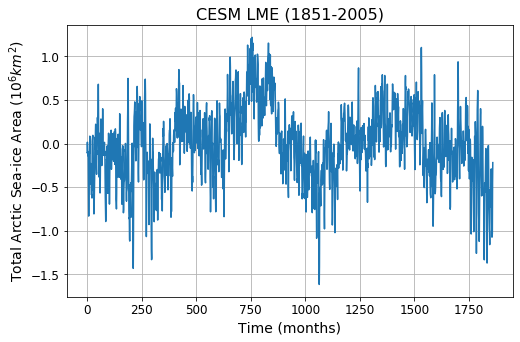

In [19]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(tot_arc_sia_lme_1851_2005/1e6)

plt.xlabel('Time (months)', fontsize=14)
plt.ylabel('Total Arctic Sea-ice Area ($10^6 km^2$)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title('CESM LME (1851-2005)', fontsize=16)

Text(0.5, 1.0, 'CESM LME (1851-2005)')

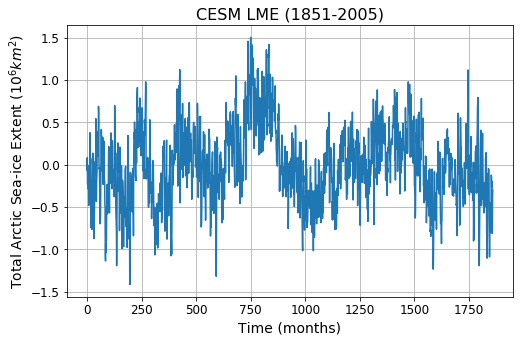

In [20]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(tot_arc_sie_lme_1851_2005/1e6)

plt.xlabel('Time (months)', fontsize=14)
plt.ylabel('Total Arctic Sea-ice Extent ($10^6 km^2$)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title('CESM LME (1851-2005)', fontsize=16)

## CCSM4 Last Millennium (850-1850):

In [21]:
train_dsource = 'cesm_le'
# train_dsource = 'era5'
# valid_dsource = 'era5'
valid_dsource = 'ccsm4_lm_regridlme'

In [22]:
exp_setup['train_dsource'] = train_dsource
exp_setup['valid_dsource'] = valid_dsource 

exp_setup['nyearsvalid'] = 1000
exp_setup['nyearstrain'] = (yrend-850)
exp_setup['nyears_startvalid'] = 1*12
exp_setup['nyearstot'] = 1155

In [23]:
fdic = limkb.build_training_dic(exp_setup['valid_dsource'])
    
Ptrunc = {}
var_dict_ccsm4_lm = {}
ntims = len(exp_setup['lags'])
print('Validation data: '+exp_setup['valid_dsource'])

tecut = int(exp_setup['nyears_startvalid']/12)+(exp_setup['nyearsvalid'])

X_var_ccsm4_lm, var_dict_ccsm4_lm = limkb.load_data(var, var_dict_ccsm4_lm, fdic, 
                                  remove_climo=exp_setup['remove_climo'], 
                                  detrend=exp_setup['detrend'], verbose=verbose, 
                                  tscut=int(exp_setup['nyears_startvalid']/12), 
                                  tecut=tecut, lat_cutoff=exp_setup['lat_cutoff'][var])

Validation data: ccsm4_lm_regridlme
Loading from sic
Loading from nium/sic_sfc_OImon_CCSM4_past1000_regridlme_085001-185012.nc
time dimension: 851 - 1850
latitude cutoff detected: 40
detrending...
Working on month...0
Found with nans (not in satellite), going to fill with zeros...
Working on month...1
Found with nans (not in satellite), going to fill with zeros...
Working on month...2
Found with nans (not in satellite), going to fill with zeros...
Working on month...3
Found with nans (not in satellite), going to fill with zeros...
Working on month...4
Found with nans (not in satellite), going to fill with zeros...
Working on month...5
Found with nans (not in satellite), going to fill with zeros...
Working on month...6
Found with nans (not in satellite), going to fill with zeros...
Working on month...7
Found with nans (not in satellite), going to fill with zeros...
Working on month...8
Found with nans (not in satellite), going to fill with zeros...
Working on month...9
Found with nans (

In [24]:
var_dict_full_og = {}

X_var_full_og, var_dict_full_og = limkb.load_data(var, var_dict_full_og, fdic, 
                                                  remove_climo=False, 
                                                  detrend=False, verbose=verbose, 
                                                  tscut=int(exp_setup['nyears_startvalid']/12), 
                                                  tecut=tecut, lat_cutoff=exp_setup['lat_cutoff'][var])

sie = np.where(X_var_full_og>=0.15,100,0)
ndof = sie.shape[0]
ntime = sie.shape[1]
remove_climo = exp_setup['remove_climo']

#Detrend: 
x_var_dt = np.zeros((ndof,int(ntime/12),12))
climo = np.zeros((ndof,12))
x_var_3d = np.reshape(sie, (ndof,int(ntime/12),12))
for i in range(12):
    print('Working on month...'+str(i))
    y = x_var_3d[:,:,i]
    if ('goddard' in fdic[var]) & (np.isnan(y).sum()>0):
        print('Found some nans in satellite data, going to fill with previous timestep...')
        inds = np.where(np.isnan(y))
        ind_int = int(inds[1].min()-1)
        fill = np.ones(y.shape)*y[:,ind_int][:,np.newaxis]
        var_nans_mask = np.where(np.isnan(y),np.nan,1)
        Y = np.where(np.isnan(y),fill,y)
    elif np.isnan(y).sum()>0: 
        print('Found with nans (not in satellite), going to fill with zeros...')
        var_nans_mask = np.where(np.isnan(y),np.nan,1)
        Y = np.where(np.isnan(y),0,y)
    else: 
        Y = y
#                print('Y = '+ str(Y.shape))
    X = np.arange(0,int(ntime/12))
    [var_dt,_,intercept] = statskb.multi_linear_detrend(X,Y,axis=1,atol=False,
                                                        remove_mn=remove_climo)
    if np.isnan(y).sum()>0:
        x_var_dt[:,:,i] = var_dt*var_nans_mask
    else: 
        x_var_dt[:,:,i] = var_dt
    climo[:,i] = intercept

x_var_anom = np.reshape(x_var_dt,(ndof,ntime))
sie_anom_ccsm4_lm = x_var_anom

Loading from sic
Loading from nium/sic_sfc_OImon_CCSM4_past1000_regridlme_085001-185012.nc
time dimension: 851 - 1850
latitude cutoff detected: 40
-----------------------------------------------------
completed in 0.32251739501953125 seconds
-----------------------------------------------------
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11


In [25]:
full_names, areawt_name, month_names = limbuild.load_full_names()

areacell_dict_all = {}
areacell = {}
areacell_dict = {}
areacell[var], areacell_dict_all[var] = limkb.load_data(areawt_name[var], areacell_dict, fdic, 
                                                       remove_climo=False, detrend=False, verbose=False, 
                                                       lat_cutoff=exp_setup['lat_cutoff'][var])

Loading from b22/Documents/SeaIceData/LME/LIMs/areacello_global_LME_02.nc
latitude cutoff detected: 40


In [26]:
units = areacell_dict_all[var][areawt_name[var]]['units']

if 'km' in units:
    acell = areacell[var]
elif 'centi' in units: 
    print('changing cellarea units from '+
          str(areacell_dict_all[var][areawt_name[var]]['units'])+' to km^2')
    acell = areacell[var]*(1e-10)
    units = 'km^2'
else: 
    print('changing cellarea units from '+
          str(areacell_dict_all[var][areawt_name[var]]['units'])+' to km^2')
    acell = areacell[var]*(1e-6)
    units = 'km^2'

changing cellarea units from centimeter^2 to km^2


In [27]:
nlon = int(var_dict_ccsm4_lm[var]['var_ndof']/var_dict_ccsm4_lm[var]['lat'].shape[0])

tot_arc_sia_ccsm4_lm = statskb.calc_tot_si_checks(X_var_ccsm4_lm,acell,units,var_dict_ccsm4_lm[var]['lat'],
                                                      nlon,lat_cutoff=0.0)
tot_arc_sie_ccsm4_lm = statskb.calc_tot_si_checks(sie_anom_ccsm4_lm,acell,units,var_dict_ccsm4_lm[var]['lat'],
                                                      nlon,lat_cutoff=0.0)

Max concentration is 98.61 ...dividing concentration by 100.
Max concentration is 102.0 ...dividing concentration by 100.


Text(0.5, 1.0, 'CCSM4 LM (850-1850)')

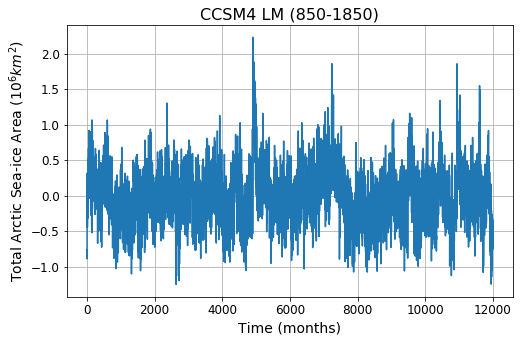

In [28]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(tot_arc_sia_ccsm4_lm/1e6)
# plt.plot(chunk_mn/1e6)

plt.xlabel('Time (months)', fontsize=14)
plt.ylabel('Total Arctic Sea-ice Area ($10^6 km^2$)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title('CCSM4 LM (850-1850)', fontsize=16)

Text(0.5, 1.0, 'CCSM4 LM (850-1850)')

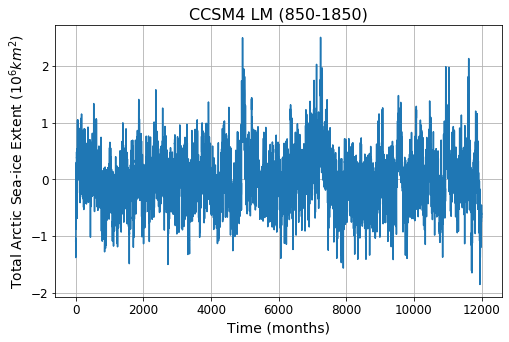

In [29]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(tot_arc_sie_ccsm4_lm/1e6)

plt.xlabel('Time (months)', fontsize=14)
plt.ylabel('Total Arctic Sea-ice Extent ($10^6 km^2$)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title('CCSM4 LM (850-1850)', fontsize=16)

## MPI Last Millennium (850-1850) - MPI grid

In [7]:
train_dsource = 'cesm_le'
# train_dsource = 'era5'
# valid_dsource = 'era5'
valid_dsource = 'mpi_lm_kb'

In [8]:
exp_setup['train_dsource'] = train_dsource
exp_setup['valid_dsource'] = valid_dsource 

exp_setup['nyearsvalid'] = 1000
exp_setup['nyearstrain'] = (yrend-850)
exp_setup['nyears_startvalid'] = 1*12
exp_setup['nyearstot'] = 1155

In [9]:
fdic = limkb.build_training_dic(exp_setup['valid_dsource'])
    
Ptrunc = {}
var_dict_mpi_lm2 = {}
ntims = len(exp_setup['lags'])
print('Validation data: '+exp_setup['valid_dsource'])

tecut = int(exp_setup['nyears_startvalid']/12)+(exp_setup['nyearsvalid'])

X_var_mpi_lm2, var_dict_mpi_lm2 = limkb.load_data(var, var_dict_mpi_lm2, fdic, 
                                  remove_climo=exp_setup['remove_climo'], 
                                  detrend=exp_setup['detrend'], verbose=verbose, 
                                  tscut=int(exp_setup['nyears_startvalid']/12), 
                                  tecut=tecut, lat_cutoff=exp_setup['lat_cutoff'][var])

Validation data: mpi_lm_kb
Loading from sic
Loading from ceData/MPI/sic_sfc_OImon_MPI-ESM-P_past1000_085001-185012.nc
time dimension: 851 - 1849
latitude cutoff detected: 40
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 62.66557478904724 seconds
-----------------------------------------------------


In [10]:
var_dict_full_og = {}

X_var_full_og, var_dict_full_og = limkb.load_data(var, var_dict_full_og, fdic, 
                                                  remove_climo=False, 
                                                  detrend=False, verbose=verbose, 
                                                  tscut=int(exp_setup['nyears_startvalid']/12), 
                                                  tecut=tecut, lat_cutoff=exp_setup['lat_cutoff'][var])

sie = np.where(X_var_full_og>=0.15,100,0)
ndof = sie.shape[0]
ntime = sie.shape[1]
remove_climo = exp_setup['remove_climo']

#Detrend: 
x_var_dt = np.zeros((ndof,int(ntime/12),12))
climo = np.zeros((ndof,12))
x_var_3d = np.reshape(sie, (ndof,int(ntime/12),12))
for i in range(12):
    print('Working on month...'+str(i))
    y = x_var_3d[:,:,i]
    if ('goddard' in fdic[var]) & (np.isnan(y).sum()>0):
        print('Found some nans in satellite data, going to fill with previous timestep...')
        inds = np.where(np.isnan(y))
        ind_int = int(inds[1].min()-1)
        fill = np.ones(y.shape)*y[:,ind_int][:,np.newaxis]
        var_nans_mask = np.where(np.isnan(y),np.nan,1)
        Y = np.where(np.isnan(y),fill,y)
    elif np.isnan(y).sum()>0: 
        print('Found with nans (not in satellite), going to fill with zeros...')
        var_nans_mask = np.where(np.isnan(y),np.nan,1)
        Y = np.where(np.isnan(y),0,y)
    else: 
        Y = y
#                print('Y = '+ str(Y.shape))
    X = np.arange(0,int(ntime/12))
    [var_dt,_,intercept] = statskb.multi_linear_detrend(X,Y,axis=1,atol=False,
                                                        remove_mn=remove_climo)
    if np.isnan(y).sum()>0:
        x_var_dt[:,:,i] = var_dt*var_nans_mask
    else: 
        x_var_dt[:,:,i] = var_dt
    climo[:,i] = intercept

x_var_anom = np.reshape(x_var_dt,(ndof,ntime))
sie_anom_mpi_lm2 = x_var_anom

Loading from sic
Loading from ceData/MPI/sic_sfc_OImon_MPI-ESM-P_past1000_085001-185012.nc
time dimension: 851 - 1849
latitude cutoff detected: 40
-----------------------------------------------------
completed in 1.9936764240264893 seconds
-----------------------------------------------------
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11


In [11]:
full_names, areawt_name, month_names = limbuild.load_full_names()

areacell_dict_all = {}
areacell = {}
areacell_dict = {}
areacell[var], areacell_dict_all[var] = limkb.load_data(areawt_name[var], areacell_dict, fdic, 
                                                       remove_climo=False, detrend=False, verbose=False, 
                                                       lat_cutoff=exp_setup['lat_cutoff'][var])

Loading from nts/SeaIceData/MPI/areacello_fx_MPI-ESM-P_past1000_r0i0p0.nc
latitude cutoff detected: 40


In [12]:
units = areacell_dict_all[var][areawt_name[var]]['units']

if 'km' in units:
    acell = areacell[var]
elif 'centi' in units: 
    print('changing cellarea units from '+
          str(areacell_dict_all[var][areawt_name[var]]['units'])+' to km^2')
    acell = areacell[var]*(1e-10)
    units = 'km^2'
else: 
    print('changing cellarea units from '+
          str(areacell_dict_all[var][areawt_name[var]]['units'])+' to km^2')
    acell = areacell[var]*(1e-6)
    units = 'km^2'

changing cellarea units from m2 to km^2


In [13]:
nlon = int(var_dict_mpi_lm2[var]['var_ndof']/var_dict_mpi_lm2[var]['lat'].shape[0])

tot_arc_sia_mpi_lm2 = statskb.calc_tot_si_checks(X_var_mpi_lm2,acell,units,var_dict_mpi_lm2[var]['lat'],
                                                      nlon,lat_cutoff=0.0)
tot_arc_sie_mpi_lm2 = statskb.calc_tot_si_checks(sie_anom_mpi_lm2,acell,units,var_dict_mpi_lm2[var]['lat'],
                                                      nlon,lat_cutoff=0.0)

Max concentration is 97.75 ...dividing concentration by 100.
Max concentration is 101.0 ...dividing concentration by 100.


Text(0.5,1,'MPI LM (850-1850)')

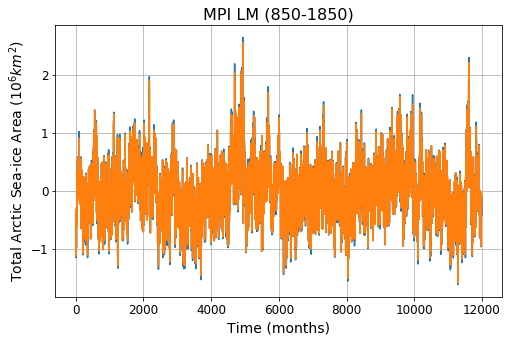

In [24]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(tot_arc_sia_mpi_lm2/1e6)
plt.plot(tot_arc_sia_mpi_lm/1e6)

plt.xlabel('Time (months)', fontsize=14)
plt.ylabel('Total Arctic Sea-ice Area ($10^6 km^2$)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title('MPI LM (850-1850)', fontsize=16)

Text(0.5,1,'MPI LM (850-1850)')

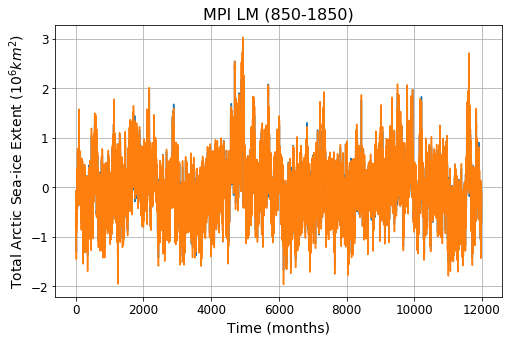

In [25]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(tot_arc_sie_mpi_lm2/1e6)
plt.plot(tot_arc_sie_mpi_lm/1e6)

plt.xlabel('Time (months)', fontsize=14)
plt.ylabel('Total Arctic Sea-ice Extent ($10^6 km^2$)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title('MPI LM (850-1850)', fontsize=16)

## MPI Last Millennium (850-1850) - LME grid

In [30]:
train_dsource = 'cesm_le'
# train_dsource = 'era5'
# valid_dsource = 'era5'
valid_dsource = 'mpi_lm_regridlme'

In [31]:
exp_setup['train_dsource'] = train_dsource
exp_setup['valid_dsource'] = valid_dsource 

exp_setup['nyearsvalid'] = 1000
exp_setup['nyearstrain'] = (yrend-850)
exp_setup['nyears_startvalid'] = 1*12
exp_setup['nyearstot'] = 1155

In [32]:
fdic = limkb.build_training_dic(exp_setup['valid_dsource'])
    
Ptrunc = {}
var_dict_mpi_lm = {}
ntims = len(exp_setup['lags'])
print('Validation data: '+exp_setup['valid_dsource'])

tecut = int(exp_setup['nyears_startvalid']/12)+(exp_setup['nyearsvalid'])

X_var_mpi_lm, var_dict_mpi_lm = limkb.load_data(var, var_dict_mpi_lm, fdic, 
                                  remove_climo=exp_setup['remove_climo'], 
                                  detrend=exp_setup['detrend'], verbose=verbose, 
                                  tscut=int(exp_setup['nyears_startvalid']/12), 
                                  tecut=tecut, lat_cutoff=exp_setup['lat_cutoff'][var])

Validation data: mpi_lm_regridlme
Loading from sic
Loading from /sic_sfc_OImon_MPI-ESM-P_past1000_regridlme_085001-185012.nc
time dimension: 851 - 1849
latitude cutoff detected: 40
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 54.983168601989746 seconds
-----------------------------------------------------


In [33]:
var_dict_full_og = {}

X_var_full_og, var_dict_full_og = limkb.load_data(var, var_dict_full_og, fdic, 
                                                  remove_climo=False, 
                                                  detrend=False, verbose=verbose, 
                                                  tscut=int(exp_setup['nyears_startvalid']/12), 
                                                  tecut=tecut, lat_cutoff=exp_setup['lat_cutoff'][var])

sie = np.where(X_var_full_og>=0.15,100,0)
ndof = sie.shape[0]
ntime = sie.shape[1]
remove_climo = exp_setup['remove_climo']

#Detrend: 
x_var_dt = np.zeros((ndof,int(ntime/12),12))
climo = np.zeros((ndof,12))
x_var_3d = np.reshape(sie, (ndof,int(ntime/12),12))
for i in range(12):
    print('Working on month...'+str(i))
    y = x_var_3d[:,:,i]
    if ('goddard' in fdic[var]) & (np.isnan(y).sum()>0):
        print('Found some nans in satellite data, going to fill with previous timestep...')
        inds = np.where(np.isnan(y))
        ind_int = int(inds[1].min()-1)
        fill = np.ones(y.shape)*y[:,ind_int][:,np.newaxis]
        var_nans_mask = np.where(np.isnan(y),np.nan,1)
        Y = np.where(np.isnan(y),fill,y)
    elif np.isnan(y).sum()>0: 
        print('Found with nans (not in satellite), going to fill with zeros...')
        var_nans_mask = np.where(np.isnan(y),np.nan,1)
        Y = np.where(np.isnan(y),0,y)
    else: 
        Y = y
#                print('Y = '+ str(Y.shape))
    X = np.arange(0,int(ntime/12))
    [var_dt,_,intercept] = statskb.multi_linear_detrend(X,Y,axis=1,atol=False,
                                                        remove_mn=remove_climo)
    if np.isnan(y).sum()>0:
        x_var_dt[:,:,i] = var_dt*var_nans_mask
    else: 
        x_var_dt[:,:,i] = var_dt
    climo[:,i] = intercept

x_var_anom = np.reshape(x_var_dt,(ndof,ntime))
sie_anom_mpi_lm = x_var_anom

Loading from sic
Loading from /sic_sfc_OImon_MPI-ESM-P_past1000_regridlme_085001-185012.nc
time dimension: 851 - 1849
latitude cutoff detected: 40
-----------------------------------------------------
completed in 0.27866268157958984 seconds
-----------------------------------------------------
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11


In [34]:
full_names, areawt_name, month_names = limbuild.load_full_names()

areacell_dict_all = {}
areacell = {}
areacell_dict = {}
areacell[var], areacell_dict_all[var] = limkb.load_data(areawt_name[var], areacell_dict, fdic, 
                                                       remove_climo=False, detrend=False, verbose=False, 
                                                       lat_cutoff=exp_setup['lat_cutoff'][var])

Loading from b22/Documents/SeaIceData/LME/LIMs/areacello_global_LME_02.nc
latitude cutoff detected: 40


In [35]:
units = areacell_dict_all[var][areawt_name[var]]['units']

if 'km' in units:
    acell = areacell[var]
elif 'centi' in units: 
    print('changing cellarea units from '+
          str(areacell_dict_all[var][areawt_name[var]]['units'])+' to km^2')
    acell = areacell[var]*(1e-10)
    units = 'km^2'
else: 
    print('changing cellarea units from '+
          str(areacell_dict_all[var][areawt_name[var]]['units'])+' to km^2')
    acell = areacell[var]*(1e-6)
    units = 'km^2'

changing cellarea units from centimeter^2 to km^2


In [36]:
nlon = int(var_dict_mpi_lm[var]['var_ndof']/var_dict_mpi_lm[var]['lat'].shape[0])

tot_arc_sia_mpi_lm = statskb.calc_tot_si_checks(X_var_mpi_lm,acell,units,var_dict_mpi_lm[var]['lat'],
                                                      nlon,lat_cutoff=0.0)
tot_arc_sie_mpi_lm = statskb.calc_tot_si_checks(sie_anom_mpi_lm,acell,units,var_dict_mpi_lm[var]['lat'],
                                                      nlon,lat_cutoff=0.0)

Max concentration is 97.7 ...dividing concentration by 100.
Max concentration is 100.0 ...dividing concentration by 100.


Text(0.5, 1.0, 'MPI LM (850-1850)')

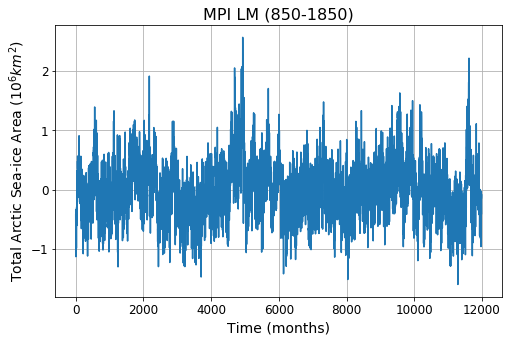

In [37]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(tot_arc_sia_mpi_lm/1e6)

plt.xlabel('Time (months)', fontsize=14)
plt.ylabel('Total Arctic Sea-ice Area ($10^6 km^2$)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title('MPI LM (850-1850)', fontsize=16)

Text(0.5, 1.0, 'MPI LM (850-1850)')

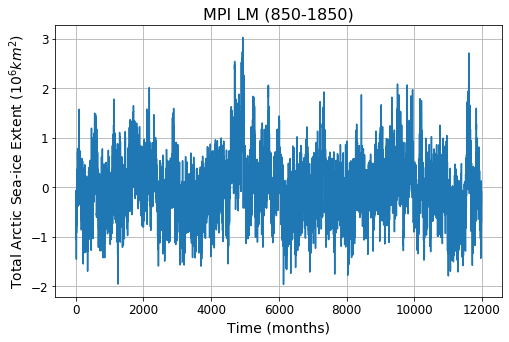

In [38]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(tot_arc_sie_mpi_lm/1e6)

plt.xlabel('Time (months)', fontsize=14)
plt.ylabel('Total Arctic Sea-ice Extent ($10^6 km^2$)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title('MPI LM (850-1850)', fontsize=16)

## CESM LE 2006-2100: 

In [39]:
train_dsource = 'cesm_lme'
# train_dsource = 'era5'
# valid_dsource = 'era5'
valid_dsource = 'cesm_le'

In [40]:
exp_setup['train_dsource'] = train_dsource
exp_setup['valid_dsource'] = valid_dsource 

exp_setup['nyearsvalid'] = 93
exp_setup['nyearstrain'] = (yrend-850)
exp_setup['nyears_startvalid'] = 1*12
exp_setup['nyearstot'] = 1155

In [41]:
fdic = limkb.build_training_dic(exp_setup['valid_dsource'])
    
Ptrunc = {}
var_dict_le = {}
ntims = len(exp_setup['lags'])
print('Validation data: '+exp_setup['valid_dsource'])

tecut = int(exp_setup['nyears_startvalid']/12)+(exp_setup['nyearsvalid'])

X_var_le, var_dict_le = limkb.load_data(var, var_dict_le, fdic, 
                                  remove_climo=exp_setup['remove_climo'], 
                                  detrend=exp_setup['detrend'], verbose=verbose, 
                                  tscut=int(exp_setup['nyears_startvalid']/12), 
                                  tecut=tecut, lat_cutoff=exp_setup['lat_cutoff'][var])

Validation data: cesm_le
Loading from sic
Loading from ments/SeaIceData/CESM_LE/sic_CESM_LE_002_nh_200601-210012.nc
time dimension: 2007 - 2100
latitude cutoff detected: 40
detrending...
Working on month...0
Found with nans (not in satellite), going to fill with zeros...
Working on month...1
Found with nans (not in satellite), going to fill with zeros...
Working on month...2
Found with nans (not in satellite), going to fill with zeros...
Working on month...3
Found with nans (not in satellite), going to fill with zeros...
Working on month...4
Found with nans (not in satellite), going to fill with zeros...
Working on month...5
Found with nans (not in satellite), going to fill with zeros...
Working on month...6
Found with nans (not in satellite), going to fill with zeros...
Working on month...7
Found with nans (not in satellite), going to fill with zeros...
Working on month...8
Found with nans (not in satellite), going to fill with zeros...
Working on month...9
Found with nans (not in sat

In [42]:
var_dict_full_og = {}

X_var_full_og, var_dict_full_og = limkb.load_data(var, var_dict_full_og, fdic, 
                                                  remove_climo=False, 
                                                  detrend=False, verbose=verbose, 
                                                  tscut=int(exp_setup['nyears_startvalid']/12), 
                                                  tecut=tecut, lat_cutoff=exp_setup['lat_cutoff'][var])

sie = np.where(X_var_full_og>=0.15,100,0)
ndof = sie.shape[0]
ntime = sie.shape[1]
remove_climo = exp_setup['remove_climo']

#Detrend: 
x_var_dt = np.zeros((ndof,int(ntime/12),12))
climo = np.zeros((ndof,12))
x_var_3d = np.reshape(sie, (ndof,int(ntime/12),12))
for i in range(12):
    print('Working on month...'+str(i))
    y = x_var_3d[:,:,i]
    if ('goddard' in fdic[var]) & (np.isnan(y).sum()>0):
        print('Found some nans in satellite data, going to fill with previous timestep...')
        inds = np.where(np.isnan(y))
        ind_int = int(inds[1].min()-1)
        fill = np.ones(y.shape)*y[:,ind_int][:,np.newaxis]
        var_nans_mask = np.where(np.isnan(y),np.nan,1)
        Y = np.where(np.isnan(y),fill,y)
    elif np.isnan(y).sum()>0: 
        print('Found with nans (not in satellite), going to fill with zeros...')
        var_nans_mask = np.where(np.isnan(y),np.nan,1)
        Y = np.where(np.isnan(y),0,y)
    else: 
        Y = y
#                print('Y = '+ str(Y.shape))
    X = np.arange(0,int(ntime/12))
    [var_dt,_,intercept] = statskb.multi_linear_detrend(X,Y,axis=1,atol=False,
                                                        remove_mn=remove_climo)
    if np.isnan(y).sum()>0:
        x_var_dt[:,:,i] = var_dt*var_nans_mask
    else: 
        x_var_dt[:,:,i] = var_dt
    climo[:,i] = intercept

x_var_anom = np.reshape(x_var_dt,(ndof,ntime))
sie_anom_le = x_var_anom

Loading from sic
Loading from ments/SeaIceData/CESM_LE/sic_CESM_LE_002_nh_200601-210012.nc
time dimension: 2007 - 2100
latitude cutoff detected: 40
-----------------------------------------------------
completed in 0.4874999523162842 seconds
-----------------------------------------------------
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11


In [43]:
full_names, areawt_name, month_names = limbuild.load_full_names()

areacell_dict_all = {}
areacell = {}
areacell_dict = {}
areacell[var], areacell_dict_all[var] = limkb.load_data(areawt_name[var], areacell_dict, fdic, 
                                                       remove_climo=False, detrend=False, verbose=False, 
                                                       lat_cutoff=exp_setup['lat_cutoff'][var])

Loading from 22/Documents/SeaIceData/CESM_LE/areacello_CESM_LE_002_tos.nc
latitude cutoff detected: 40


In [44]:
units = areacell_dict_all[var][areawt_name[var]]['units']

if 'km' in units:
    acell = areacell[var]
elif 'centi' in units: 
    print('changing cellarea units from '+
          str(areacell_dict_all[var][areawt_name[var]]['units'])+' to km^2')
    acell = areacell[var]*(1e-10)
    units = 'km^2'
else: 
    print('changing cellarea units from '+
          str(areacell_dict_all[var][areawt_name[var]]['units'])+' to km^2')
    acell = areacell[var]*(1e-6)
    units = 'km^2'

changing cellarea units from centimeter^2 to km^2


In [45]:
nlon = int(var_dict_le[var]['var_ndof']/var_dict_le[var]['lat'].shape[0])

tot_arc_sia_le_2006_2100 = statskb.calc_tot_si_checks(X_var_le,acell,units,var_dict_le[var]['lat'],
                                                      nlon,lat_cutoff=0.0)
tot_arc_sie_le_2006_2100 = statskb.calc_tot_si_checks(sie_anom_le,acell,units,var_dict_le[var]['lat'],
                                                      nlon,lat_cutoff=0.0)

Max concentration is 94.37 ...dividing concentration by 100.
Max concentration is 109.0 ...dividing concentration by 100.


In [31]:
start = np.arange(0,93-50,10)
chunk_mn = np.zeros((len(start)))

for i,s in enumerate(start):
    chunk_mn[i] = np.nanmean(tot_arc_sia_le_2006_2100[s*12:(s+50)*12])
    print(chunk_mn[i]/1e6)


0.02802932942782644
0.06295158486113825
0.03954137347329101
0.03979883526496375
0.0021285791157633627


Text(0.5, 1.0, 'CESM LE (2006-2100)')

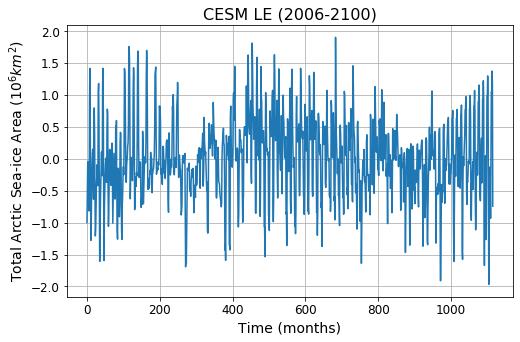

In [46]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(tot_arc_sia_le_2006_2100/1e6)

plt.xlabel('Time (months)', fontsize=14)
plt.ylabel('Total Arctic Sea-ice Area ($10^6 km^2$)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title('CESM LE (2006-2100)', fontsize=16)

Text(0.5, 1.0, 'CESM LE (2006-2100)')

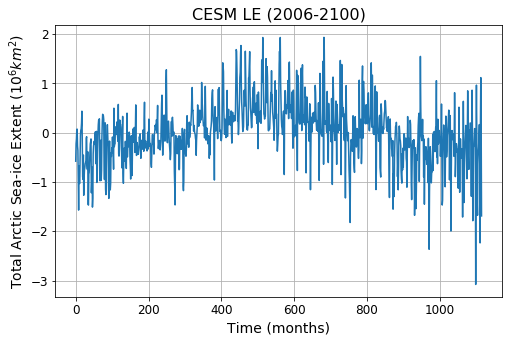

In [47]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(tot_arc_sie_le_2006_2100/1e6)

plt.xlabel('Time (months)', fontsize=14)
plt.ylabel('Total Arctic Sea-ice Extent ($10^6 km^2$)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title('CESM LE (2006-2100)', fontsize=16)

In [48]:
tot_sia_anmn = np.nanmean(np.reshape((tot_arc_sia_le_2006_2100/1e6),(93,12)),axis=1)
tot_sia_2d = np.reshape((tot_arc_sia_le_2006_2100/1e6),(93,12))

In [36]:
start = np.arange(0,93-50,10)
chunk_mn = np.zeros((len(start)))

for i,s in enumerate(start):
    chunk_mn[i] = np.nanmean(tot_sia_anmn[s:(s+50)])
    print(chunk_mn[i])

0.028029329427826443
0.06295158486113828
0.039541373473291
0.039798835264963764
0.002128579115763368


Text(0.5,1,'CESM LE (2006-2100)')

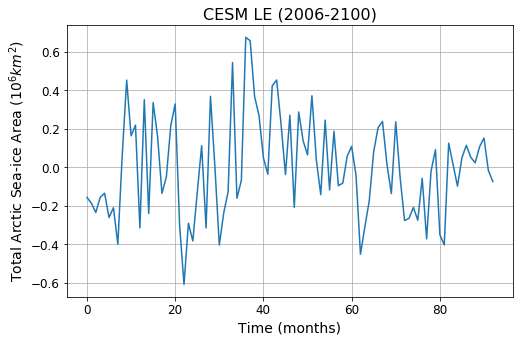

In [37]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(tot_sia_anmn)

plt.xlabel('Time (months)', fontsize=14)
plt.ylabel('Total Arctic Sea-ice Area ($10^6 km^2$)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title('CESM LE (2006-2100)', fontsize=16)

## CMIP6 CESM2 Historical Simulation: 

In [49]:
train_dsource = 'cesm_lme'
# train_dsource = 'era5'
# valid_dsource = 'era5'
valid_dsource = 'cmip6_cesm2_hist'

var = 'sic'

In [50]:
exp_setup['train_dsource'] = train_dsource
exp_setup['valid_dsource'] = valid_dsource 

exp_setup['nyearsvalid'] = 165
exp_setup['nyearstrain'] = (yrend-850)
exp_setup['nyears_startvalid'] = 1*12
exp_setup['nyearstot'] = 1155

In [51]:
fdic = limkb.build_training_dic(exp_setup['valid_dsource'])
    
Ptrunc = {}
var_dict_cesm2_hist = {}
ntims = len(exp_setup['lags'])
print('Validation data: '+exp_setup['valid_dsource'])

tecut = int(exp_setup['nyears_startvalid']/12)+(exp_setup['nyearsvalid'])

X_var_cesm2_hist, var_dict_cesm2_hist = limkb.load_data(var, var_dict_cesm2_hist, fdic, 
                                                      remove_climo=exp_setup['remove_climo'], 
                                                      detrend=exp_setup['detrend'], verbose=verbose, 
                                                      tscut=int(exp_setup['nyears_startvalid']/12), 
                                                      tecut=tecut, lat_cutoff=exp_setup['lat_cutoff'][var])

Validation data: cmip6_cesm2_hist
Loading from sic
Loading from ical/sic_SImon_CESM2_historical_r1i1p1f1_gn_185001-201412.nc
time dimension: 1851 - 2014
latitude cutoff detected: 40
detrending...
Working on month...0
Found with nans (not in satellite), going to fill with zeros...
Working on month...1
Found with nans (not in satellite), going to fill with zeros...
Working on month...2
Found with nans (not in satellite), going to fill with zeros...
Working on month...3
Found with nans (not in satellite), going to fill with zeros...
Working on month...4
Found with nans (not in satellite), going to fill with zeros...
Working on month...5
Found with nans (not in satellite), going to fill with zeros...
Working on month...6
Found with nans (not in satellite), going to fill with zeros...
Working on month...7
Found with nans (not in satellite), going to fill with zeros...
Working on month...8
Found with nans (not in satellite), going to fill with zeros...
Working on month...9
Found with nans (n

In [52]:
var_dict_full_og = {}

X_var_full_og, var_dict_full_og = limkb.load_data(var, var_dict_full_og, fdic, 
                                                  remove_climo=False, 
                                                  detrend=False, verbose=verbose, 
                                                  tscut=int(exp_setup['nyears_startvalid']/12), 
                                                  tecut=tecut, lat_cutoff=exp_setup['lat_cutoff'][var])

sie = np.where(X_var_full_og>=0.15,100,0)
ndof = sie.shape[0]
ntime = sie.shape[1]
remove_climo = exp_setup['remove_climo']

#Detrend: 
x_var_dt = np.zeros((ndof,int(ntime/12),12))
climo = np.zeros((ndof,12))
x_var_3d = np.reshape(sie, (ndof,int(ntime/12),12))
for i in range(12):
    print('Working on month...'+str(i))
    y = x_var_3d[:,:,i]
    if ('goddard' in fdic[var]) & (np.isnan(y).sum()>0):
        print('Found some nans in satellite data, going to fill with previous timestep...')
        inds = np.where(np.isnan(y))
        ind_int = int(inds[1].min()-1)
        fill = np.ones(y.shape)*y[:,ind_int][:,np.newaxis]
        var_nans_mask = np.where(np.isnan(y),np.nan,1)
        Y = np.where(np.isnan(y),fill,y)
    elif np.isnan(y).sum()>0: 
        print('Found with nans (not in satellite), going to fill with zeros...')
        var_nans_mask = np.where(np.isnan(y),np.nan,1)
        Y = np.where(np.isnan(y),0,y)
    else: 
        Y = y
#                print('Y = '+ str(Y.shape))
    X = np.arange(0,int(ntime/12))
    [var_dt,_,intercept] = statskb.multi_linear_detrend(X,Y,axis=1,atol=False,
                                                        remove_mn=remove_climo)
    if np.isnan(y).sum()>0:
        x_var_dt[:,:,i] = var_dt*var_nans_mask
    else: 
        x_var_dt[:,:,i] = var_dt
    climo[:,i] = intercept

x_var_anom = np.reshape(x_var_dt,(ndof,ntime))
sie_anom_cesm2_hist = x_var_anom

Loading from sic
Loading from ical/sic_SImon_CESM2_historical_r1i1p1f1_gn_185001-201412.nc
time dimension: 1851 - 2014
latitude cutoff detected: 40
-----------------------------------------------------
completed in 2.3561830520629883 seconds
-----------------------------------------------------
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11


In [53]:
full_names, areawt_name, month_names = limbuild.load_full_names()

areacell_dict_all = {}
areacell = {}
areacell_dict = {}
areacell[var], areacell_dict_all[var] = limkb.load_data(areawt_name[var], areacell_dict, fdic, 
                                                       remove_climo=False, detrend=False, verbose=False, 
                                                       lat_cutoff=exp_setup['lat_cutoff'][var])

Loading from m2-historical/areacello_Ofx_CESM2_historical_r11i1p1f1_gn.nc
latitude cutoff detected: 40


In [54]:
units = areacell_dict_all[var][areawt_name[var]]['units']

if 'km' in units:
    acell = areacell[var]
elif 'centi' in units: 
    print('changing cellarea units from '+
          str(areacell_dict_all[var][areawt_name[var]]['units'])+' to km^2')
    acell = areacell[var]*(1e-10)
    units = 'km^2'
else: 
    print('changing cellarea units from '+
          str(areacell_dict_all[var][areawt_name[var]]['units'])+' to km^2')
    acell = areacell[var]*(1e-6)
    units = 'km^2'

changing cellarea units from m2 to km^2


In [55]:
nlon = int(var_dict_cesm2_hist[var]['var_ndof']/var_dict_cesm2_hist[var]['lat'].shape[0])

tot_arc_sia_cesm2_hist_1850_2014 = statskb.calc_tot_si_checks(X_var_cesm2_hist,acell,units,
                                                              var_dict_cesm2_hist[var]['lat'],
                                                              nlon,lat_cutoff=0.0)
tot_arc_sie_cesm2_hist_1850_2014 = statskb.calc_tot_si_checks(sie_anom_cesm2_hist,acell,units,
                                                              var_dict_cesm2_hist[var]['lat'],
                                                              nlon,lat_cutoff=0.0)

Max concentration is 94.9 ...dividing concentration by 100.
Max concentration is 108.0 ...dividing concentration by 100.


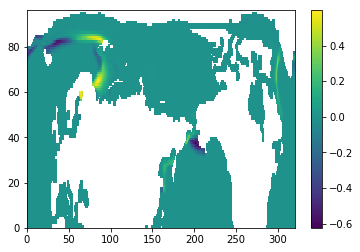

In [41]:
plt.pcolormesh(np.reshape(X_var_cesm2_hist[:,0],(96,320))/100)
plt.colorbar()

Text(0.5, 1.0, 'CESM2 Historical (1850-2014)')

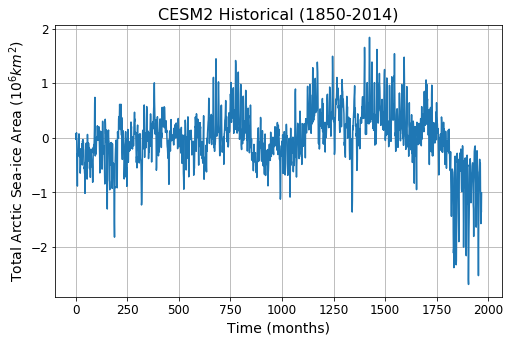

In [56]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(tot_arc_sia_cesm2_hist_1850_2014/1e6)

plt.xlabel('Time (months)', fontsize=14)
plt.ylabel('Total Arctic Sea-ice Area ($10^6 km^2$)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title('CESM2 Historical (1850-2014)', fontsize=16)

Text(0.5, 1.0, 'CESM2 Historical (1850-2014)')

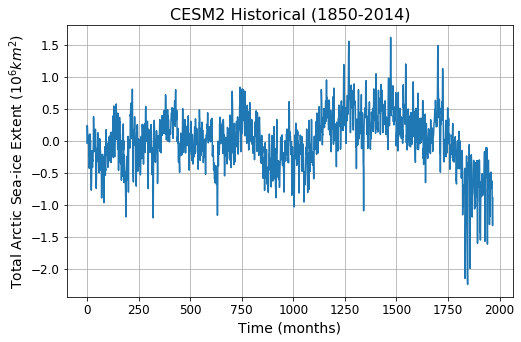

In [57]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(tot_arc_sie_cesm2_hist_1850_2014/1e6)

plt.xlabel('Time (months)', fontsize=14)
plt.ylabel('Total Arctic Sea-ice Extent ($10^6 km^2$)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title('CESM2 Historical (1850-2014)', fontsize=16)

## CMIP6 MPI Historical Simulation: 

In [58]:
train_dsource = 'cesm_lme'
# train_dsource = 'era5'
# valid_dsource = 'era5'
valid_dsource = 'cmip6_mpi_hist_regridlme'

In [59]:
exp_setup['train_dsource'] = train_dsource
exp_setup['valid_dsource'] = valid_dsource 

exp_setup['nyearsvalid'] = 165
exp_setup['nyearstrain'] = (yrend-850)
exp_setup['nyears_startvalid'] = 1*12
exp_setup['nyearstot'] = 1155

In [60]:
2014-1850

164

In [61]:
fdic = limkb.build_training_dic(exp_setup['valid_dsource'])
    
Ptrunc = {}
var_dict_mpi_hist = {}
ntims = len(exp_setup['lags'])
print('Validation data: '+exp_setup['valid_dsource'])

tecut = int(exp_setup['nyears_startvalid']/12)+(exp_setup['nyearsvalid'])

X_var_mpi_hist, var_dict_mpi_hist = limkb.load_data(var, var_dict_mpi_hist, fdic, 
                                                  remove_climo=exp_setup['remove_climo'], 
                                                  detrend=exp_setup['detrend'], verbose=verbose, 
                                                  tscut=int(exp_setup['nyears_startvalid']/12), 
                                                  tecut=tecut, lat_cutoff=exp_setup['lat_cutoff'][var])

Validation data: cmip6_mpi_hist_regridlme
Loading from sic
Loading from MPI-ESM1-2-LR_historical_r1i1p1f1_regridlme_185001-201412.nc
time dimension: 1851 - 2014
latitude cutoff detected: 40
detrending...
Working on month...0
Found with nans (not in satellite), going to fill with zeros...
Working on month...1
Found with nans (not in satellite), going to fill with zeros...
Working on month...2
Found with nans (not in satellite), going to fill with zeros...
Working on month...3
Found with nans (not in satellite), going to fill with zeros...
Working on month...4
Found with nans (not in satellite), going to fill with zeros...
Working on month...5
Found with nans (not in satellite), going to fill with zeros...
Working on month...6
Found with nans (not in satellite), going to fill with zeros...
Working on month...7
Found with nans (not in satellite), going to fill with zeros...
Working on month...8
Found with nans (not in satellite), going to fill with zeros...
Working on month...9
Found with

In [62]:
var_dict_full_og = {}

X_var_full_og, var_dict_full_og = limkb.load_data(var, var_dict_full_og, fdic, 
                                                  remove_climo=False, 
                                                  detrend=False, verbose=verbose, 
                                                  tscut=int(exp_setup['nyears_startvalid']/12), 
                                                  tecut=tecut, lat_cutoff=exp_setup['lat_cutoff'][var])

sie = np.where(X_var_full_og>=0.15,100,0)
ndof = sie.shape[0]
ntime = sie.shape[1]
remove_climo = exp_setup['remove_climo']

#Detrend: 
x_var_dt = np.zeros((ndof,int(ntime/12),12))
climo = np.zeros((ndof,12))
x_var_3d = np.reshape(sie, (ndof,int(ntime/12),12))
for i in range(12):
    print('Working on month...'+str(i))
    y = x_var_3d[:,:,i]
    if ('goddard' in fdic[var]) & (np.isnan(y).sum()>0):
        print('Found some nans in satellite data, going to fill with previous timestep...')
        inds = np.where(np.isnan(y))
        ind_int = int(inds[1].min()-1)
        fill = np.ones(y.shape)*y[:,ind_int][:,np.newaxis]
        var_nans_mask = np.where(np.isnan(y),np.nan,1)
        Y = np.where(np.isnan(y),fill,y)
    elif np.isnan(y).sum()>0: 
        print('Found with nans (not in satellite), going to fill with zeros...')
        var_nans_mask = np.where(np.isnan(y),np.nan,1)
        Y = np.where(np.isnan(y),0,y)
    else: 
        Y = y
#                print('Y = '+ str(Y.shape))
    X = np.arange(0,int(ntime/12))
    [var_dt,_,intercept] = statskb.multi_linear_detrend(X,Y,axis=1,atol=False,
                                                        remove_mn=remove_climo)
    if np.isnan(y).sum()>0:
        x_var_dt[:,:,i] = var_dt*var_nans_mask
    else: 
        x_var_dt[:,:,i] = var_dt
    climo[:,i] = intercept

x_var_anom = np.reshape(x_var_dt,(ndof,ntime))
sie_anom_mpi_hist = x_var_anom

Loading from sic
Loading from MPI-ESM1-2-LR_historical_r1i1p1f1_regridlme_185001-201412.nc
time dimension: 1851 - 2014
latitude cutoff detected: 40
-----------------------------------------------------
completed in 0.05469179153442383 seconds
-----------------------------------------------------
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11


In [63]:
full_names, areawt_name, month_names = limbuild.load_full_names()

areacell_dict_all = {}
areacell = {}
areacell_dict = {}
areacell[var], areacell_dict_all[var] = limkb.load_data(areawt_name[var], areacell_dict, fdic, 
                                                       remove_climo=False, detrend=False, verbose=False, 
                                                       lat_cutoff=exp_setup['lat_cutoff'][var])

Loading from b22/Documents/SeaIceData/LME/LIMs/areacello_global_LME_02.nc
latitude cutoff detected: 40


In [64]:
units = areacell_dict_all[var][areawt_name[var]]['units']

if 'km' in units:
    acell = areacell[var]
elif 'centi' in units: 
    print('changing cellarea units from '+
          str(areacell_dict_all[var][areawt_name[var]]['units'])+' to km^2')
    acell = areacell[var]*(1e-10)
    units = 'km^2'
else: 
    print('changing cellarea units from '+
          str(areacell_dict_all[var][areawt_name[var]]['units'])+' to km^2')
    acell = areacell[var]*(1e-6)
    units = 'km^2'

changing cellarea units from centimeter^2 to km^2


In [65]:
nlon = int(var_dict_mpi_hist[var]['var_ndof']/var_dict_mpi_hist[var]['lat'].shape[0])

tot_arc_sia_mpi_hist_1850_2014 = statskb.calc_tot_si_checks(X_var_mpi_hist,acell,units,
                                                            var_dict_mpi_hist[var]['lat'],
                                                            nlon,lat_cutoff=0.0)
tot_arc_sie_mpi_hist_1850_2014 = statskb.calc_tot_si_checks(sie_anom_mpi_hist,acell,units,
                                                            var_dict_mpi_hist[var]['lat'],
                                                            nlon,lat_cutoff=0.0)

Max concentration is 95.51 ...dividing concentration by 100.
Max concentration is 106.0 ...dividing concentration by 100.


Text(0.5, 1.0, 'MPI Historical (1850-2014)')

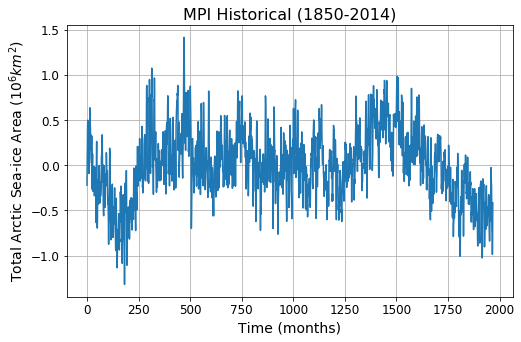

In [66]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(tot_arc_sia_mpi_hist_1850_2014/1e6)

plt.xlabel('Time (months)', fontsize=14)
plt.ylabel('Total Arctic Sea-ice Area ($10^6 km^2$)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title('MPI Historical (1850-2014)', fontsize=16)

Text(0.5, 1.0, 'MPI Historical (1850-2014)')

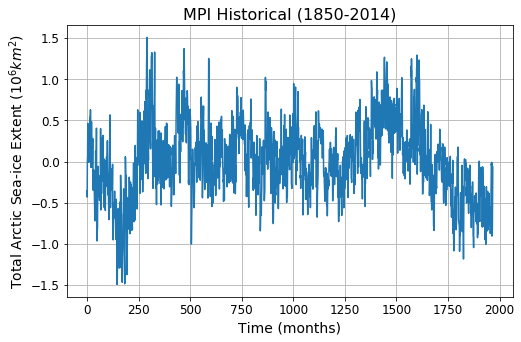

In [67]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(tot_arc_sie_mpi_hist_1850_2014/1e6)

plt.xlabel('Time (months)', fontsize=14)
plt.ylabel('Total Arctic Sea-ice Extent ($10^6 km^2$)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title('MPI Historical (1850-2014)', fontsize=16)

## CMIP6 GFDL Historical simulation: 

In [68]:
train_dsource = 'cesm_lme'
# train_dsource = 'era5'
# valid_dsource = 'era5'
valid_dsource = 'cmip6_gfdl_hist_regridlme'

In [69]:
exp_setup['train_dsource'] = train_dsource
exp_setup['valid_dsource'] = valid_dsource 

exp_setup['nyearsvalid'] = 165
exp_setup['nyearstrain'] = (yrend-850)
exp_setup['nyears_startvalid'] = 1*12
exp_setup['nyearstot'] = 1155

In [70]:
fdic = limkb.build_training_dic(exp_setup['valid_dsource'])
    
Ptrunc = {}
var_dict_gfdl_hist = {}
ntims = len(exp_setup['lags'])
print('Validation data: '+exp_setup['valid_dsource'])

tecut = int(exp_setup['nyears_startvalid']/12)+(exp_setup['nyearsvalid'])

X_var_gfdl_hist, var_dict_gfdl_hist = limkb.load_data(var, var_dict_gfdl_hist, fdic, 
                                                  remove_climo=exp_setup['remove_climo'], 
                                                  detrend=exp_setup['detrend'], verbose=verbose, 
                                                  tscut=int(exp_setup['nyears_startvalid']/12), 
                                                  tecut=tecut, lat_cutoff=exp_setup['lat_cutoff'][var])

Validation data: cmip6_gfdl_hist_regridlme
Loading from sic
Loading from mon_GFDL-ESM4_historical_r1i1p1f1_regridlme_185001-201412.nc
time dimension: 1851 - 2014
latitude cutoff detected: 40
detrending...
Working on month...0
Found with nans (not in satellite), going to fill with zeros...
Working on month...1
Found with nans (not in satellite), going to fill with zeros...
Working on month...2
Found with nans (not in satellite), going to fill with zeros...
Working on month...3
Found with nans (not in satellite), going to fill with zeros...
Working on month...4
Found with nans (not in satellite), going to fill with zeros...
Working on month...5
Found with nans (not in satellite), going to fill with zeros...
Working on month...6
Found with nans (not in satellite), going to fill with zeros...
Working on month...7
Found with nans (not in satellite), going to fill with zeros...
Working on month...8
Found with nans (not in satellite), going to fill with zeros...
Working on month...9
Found wit

In [71]:
var_dict_full_og = {}

X_var_full_og, var_dict_full_og = limkb.load_data(var, var_dict_full_og, fdic, 
                                                  remove_climo=False, 
                                                  detrend=False, verbose=verbose, 
                                                  tscut=int(exp_setup['nyears_startvalid']/12), 
                                                  tecut=tecut, lat_cutoff=exp_setup['lat_cutoff'][var])

sie = np.where(X_var_full_og>=0.15,100,0)
ndof = sie.shape[0]
ntime = sie.shape[1]
remove_climo = exp_setup['remove_climo']

#Detrend: 
x_var_dt = np.zeros((ndof,int(ntime/12),12))
climo = np.zeros((ndof,12))
x_var_3d = np.reshape(sie, (ndof,int(ntime/12),12))
for i in range(12):
    print('Working on month...'+str(i))
    y = x_var_3d[:,:,i]
    if ('goddard' in fdic[var]) & (np.isnan(y).sum()>0):
        print('Found some nans in satellite data, going to fill with previous timestep...')
        inds = np.where(np.isnan(y))
        ind_int = int(inds[1].min()-1)
        fill = np.ones(y.shape)*y[:,ind_int][:,np.newaxis]
        var_nans_mask = np.where(np.isnan(y),np.nan,1)
        Y = np.where(np.isnan(y),fill,y)
    elif np.isnan(y).sum()>0: 
        print('Found with nans (not in satellite), going to fill with zeros...')
        var_nans_mask = np.where(np.isnan(y),np.nan,1)
        Y = np.where(np.isnan(y),0,y)
    else: 
        Y = y
#                print('Y = '+ str(Y.shape))
    X = np.arange(0,int(ntime/12))
    [var_dt,_,intercept] = statskb.multi_linear_detrend(X,Y,axis=1,atol=False,
                                                        remove_mn=remove_climo)
    if np.isnan(y).sum()>0:
        x_var_dt[:,:,i] = var_dt*var_nans_mask
    else: 
        x_var_dt[:,:,i] = var_dt
    climo[:,i] = intercept

x_var_anom = np.reshape(x_var_dt,(ndof,ntime))
sie_anom_gfdl_hist = x_var_anom

Loading from sic
Loading from mon_GFDL-ESM4_historical_r1i1p1f1_regridlme_185001-201412.nc
time dimension: 1851 - 2014
latitude cutoff detected: 40
-----------------------------------------------------
completed in 0.06113386154174805 seconds
-----------------------------------------------------
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11


In [72]:
full_names, areawt_name, month_names = limbuild.load_full_names()

areacell_dict_all = {}
areacell = {}
areacell_dict = {}
areacell[var], areacell_dict_all[var] = limkb.load_data(areawt_name[var], areacell_dict, fdic, 
                                                       remove_climo=False, detrend=False, verbose=False, 
                                                       lat_cutoff=exp_setup['lat_cutoff'][var])

Loading from b22/Documents/SeaIceData/LME/LIMs/areacello_global_LME_02.nc
latitude cutoff detected: 40


In [73]:
units = areacell_dict_all[var][areawt_name[var]]['units']

if 'km' in units:
    acell = areacell[var]
elif 'centi' in units: 
    print('changing cellarea units from '+
          str(areacell_dict_all[var][areawt_name[var]]['units'])+' to km^2')
    acell = areacell[var]*(1e-10)
    units = 'km^2'
else: 
    print('changing cellarea units from '+
          str(areacell_dict_all[var][areawt_name[var]]['units'])+' to km^2')
    acell = areacell[var]*(1e-6)
    units = 'km^2'

changing cellarea units from centimeter^2 to km^2


In [74]:
nlon = int(var_dict_gfdl_hist[var]['var_ndof']/var_dict_gfdl_hist[var]['lat'].shape[0])

tot_arc_sia_gfdl_hist_1850_2014 = statskb.calc_tot_si_checks(X_var_gfdl_hist,acell,units,
                                                            var_dict_gfdl_hist[var]['lat'],
                                                            nlon,lat_cutoff=0.0)
tot_arc_sie_gfdl_hist_1850_2014 = statskb.calc_tot_si_checks(sie_anom_gfdl_hist,acell,units,
                                                            var_dict_gfdl_hist[var]['lat'],
                                                            nlon,lat_cutoff=0.0)

Max concentration is 96.22 ...dividing concentration by 100.
Max concentration is 103.0 ...dividing concentration by 100.


Text(0.5, 1.0, 'GFDL Historical (1850-2014)')

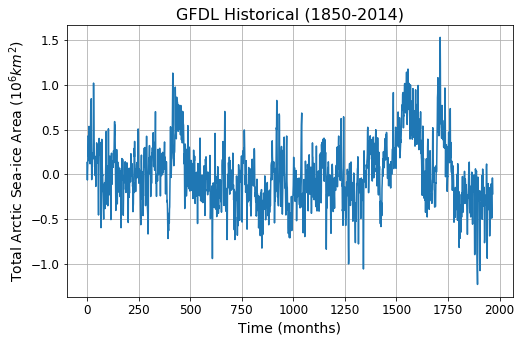

In [75]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(tot_arc_sia_gfdl_hist_1850_2014/1e6)

plt.xlabel('Time (months)', fontsize=14)
plt.ylabel('Total Arctic Sea-ice Area ($10^6 km^2$)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title('GFDL Historical (1850-2014)', fontsize=16)

Text(0.5, 1.0, 'GFDL Historical (1850-2014)')

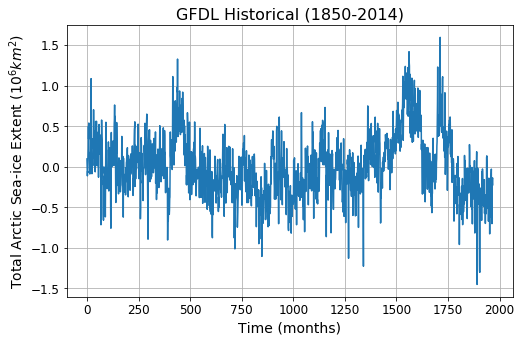

In [76]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(tot_arc_sie_gfdl_hist_1850_2014/1e6)

plt.xlabel('Time (months)', fontsize=14)
plt.ylabel('Total Arctic Sea-ice Extent ($10^6 km^2$)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title('GFDL Historical (1850-2014)', fontsize=16)

In [159]:
X_var_gfdl_hist.shape

(30720, 1968)

## CMIP6 CanESM5 Historical simulation: 

In [166]:
train_dsource = 'cesm_lme'
# train_dsource = 'era5'
# valid_dsource = 'era5'
valid_dsource = 'cmip6_CanESM_hist_regridlme'

In [167]:
exp_setup['train_dsource'] = train_dsource
exp_setup['valid_dsource'] = valid_dsource 

exp_setup['nyearsvalid'] = 165
exp_setup['nyearstrain'] = (yrend-850)
exp_setup['nyears_startvalid'] = 1*12
exp_setup['nyearstot'] = 1155

In [171]:
X_var_canESM_hist, var_dict_canESM_hist, fdic_canESM_hist, tecut_canESM_hist = load_sic_data(var, exp_setup)

sie_anom_canESM_hist= load_sie_data(var, fdic_canESM_hist, exp_setup, tecut_canESM_hist)

[tot_arc_sia_canESM_hist_1850_2014, 
 tot_arc_sie_canESM_hist_1850_2014] = calc_tot_sia_sie(var, fdic_canESM_hist, X_var_canESM_hist, 
                                                     sie_anom_canESM_hist, var_dict_canESM_hist)

Validation data: cmip6_CanESM_hist_regridlme
Loading from sic
Loading from SImon_CanESM5_historical_r1i1p2f1_regridlme_185001-201412.nc
time dimension: 1851 - 2014
latitude cutoff detected: 40
detrending...
Working on month...0
Found with nans (not in satellite), going to fill with zeros...
Working on month...1
Found with nans (not in satellite), going to fill with zeros...
Working on month...2
Found with nans (not in satellite), going to fill with zeros...
Working on month...3
Found with nans (not in satellite), going to fill with zeros...
Working on month...4
Found with nans (not in satellite), going to fill with zeros...
Working on month...5
Found with nans (not in satellite), going to fill with zeros...
Working on month...6
Found with nans (not in satellite), going to fill with zeros...
Working on month...7
Found with nans (not in satellite), going to fill with zeros...
Working on month...8
Found with nans (not in satellite), going to fill with zeros...
Working on month...9
Found w

Text(0.5, 1.0, 'CanESM5 Historical (1850-2014)')

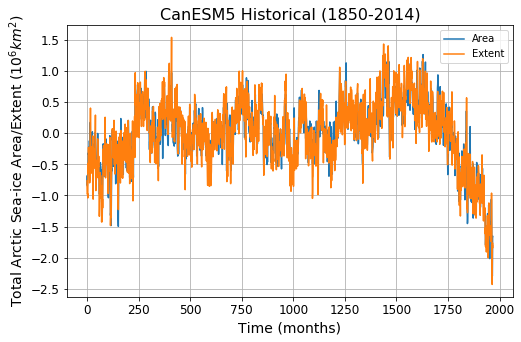

In [172]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(tot_arc_sia_canESM_hist_1850_2014/1e6, label='Area')
plt.plot(tot_arc_sie_canESM_hist_1850_2014/1e6, label='Extent')

plt.xlabel('Time (months)', fontsize=14)
plt.ylabel('Total Arctic Sea-ice Area/Extent ($10^6 km^2$)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()

plt.title('CanESM5 Historical (1850-2014)', fontsize=16)

## CMIP6 HadGEM3 Historical simulation: 

In [173]:
train_dsource = 'cesm_lme'
# train_dsource = 'era5'
# valid_dsource = 'era5'
valid_dsource = 'cmip6_HadGEM3_hist_regridlme'

In [174]:
exp_setup['train_dsource'] = train_dsource
exp_setup['valid_dsource'] = valid_dsource 

exp_setup['nyearsvalid'] = 165
exp_setup['nyearstrain'] = (yrend-850)
exp_setup['nyears_startvalid'] = 1*12
exp_setup['nyearstot'] = 1155

In [175]:
X_var_hadGEM3_hist, var_dict_hadGEM3_hist, fdic_hadGEM3_hist, tecut_hadGEM3_hist = load_sic_data(var, exp_setup)

sie_anom_hadGEM3_hist= load_sie_data(var, fdic_hadGEM3_hist, exp_setup, tecut_hadGEM3_hist)

[tot_arc_sia_hadGEM3_hist_1850_2014, 
 tot_arc_sie_hadGEM3_hist_1850_2014] = calc_tot_sia_sie(var, fdic_hadGEM3_hist, X_var_hadGEM3_hist, 
                                                     sie_anom_hadGEM3_hist, var_dict_hadGEM3_hist)

Validation data: cmip6_HadGEM3_hist_regridlme
Loading from sic
Loading from dGEM3-GC31-LL_historical_r1i1p1f3_regridlme_185001-201412.nc
time dimension: 1851 - 2014
latitude cutoff detected: 40
detrending...
Working on month...0
Found with nans (not in satellite), going to fill with zeros...
Working on month...1
Found with nans (not in satellite), going to fill with zeros...
Working on month...2
Found with nans (not in satellite), going to fill with zeros...
Working on month...3
Found with nans (not in satellite), going to fill with zeros...
Working on month...4
Found with nans (not in satellite), going to fill with zeros...
Working on month...5
Found with nans (not in satellite), going to fill with zeros...
Working on month...6
Found with nans (not in satellite), going to fill with zeros...
Working on month...7
Found with nans (not in satellite), going to fill with zeros...
Working on month...8
Found with nans (not in satellite), going to fill with zeros...
Working on month...9
Found 

Text(0.5, 1.0, 'HadGEM3 Historical (1850-2014)')

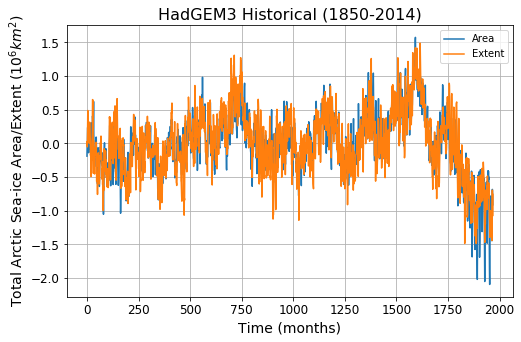

In [176]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(tot_arc_sia_hadGEM3_hist_1850_2014/1e6, label='Area')
plt.plot(tot_arc_sie_hadGEM3_hist_1850_2014/1e6, label='Extent')

plt.xlabel('Time (months)', fontsize=14)
plt.ylabel('Total Arctic Sea-ice Area/Extent ($10^6 km^2$)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()

plt.title('HadGEM3 Historical (1850-2014)', fontsize=16)

## Satellite data: 

In [77]:
train_dsource = 'cesm_lme'
# train_dsource = 'era5'
# valid_dsource = 'era5'
valid_dsource = 'satellite_regridlme'

In [78]:
2016-1979

37

In [79]:
exp_setup['train_dsource'] = train_dsource
exp_setup['valid_dsource'] = valid_dsource 

exp_setup['nyearsvalid'] = 36
exp_setup['nyearstrain'] = (yrend-850)
exp_setup['nyears_startvalid'] = 1*12
exp_setup['nyearstot'] = 1155

In [80]:
fdic = limkb.build_training_dic(exp_setup['valid_dsource'])
    
Ptrunc = {}
var_dict_sat = {}
ntims = len(exp_setup['lags'])
print('Validation data: '+exp_setup['valid_dsource'])

tecut = int(exp_setup['nyears_startvalid']/12)+(exp_setup['nyearsvalid'])

X_var_sat, var_dict_sat = limkb.load_data(var, var_dict_sat, fdic, 
                                  remove_climo=exp_setup['remove_climo'], 
                                  detrend=exp_setup['detrend'], verbose=verbose, 
                                  tscut=int(exp_setup['nyears_startvalid']/12), 
                                  tecut=tecut, lat_cutoff=exp_setup['lat_cutoff'][var])

Validation data: satellite_regridlme
Loading from sic
Loading from vations/sic_goddard_merged_mon_v03r01_regridlme_1979_2016.nc
time dimension: 1980 - 2015
latitude cutoff detected: 40
detrending...
Working on month...0
Found some nans in satellite data, going to fill with previous timestep...
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
Found some nans in satellite data, going to fill with previous timestep...
-----------------------------------------------------
completed in 23.08578395843506 seconds
-----------------------------------------------------


In [81]:
var_dict_full_og = {}

X_var_full_og, var_dict_full_og = limkb.load_data(var, var_dict_full_og, fdic, 
                                                  remove_climo=False, 
                                                  detrend=False, verbose=verbose, 
                                                  tscut=int(exp_setup['nyears_startvalid']/12), 
                                                  tecut=tecut, lat_cutoff=exp_setup['lat_cutoff'][var])

sie = np.where(X_var_full_og>=0.15,100,0)
ndof = sie.shape[0]
ntime = sie.shape[1]
remove_climo = exp_setup['remove_climo']

#Detrend: 
x_var_dt = np.zeros((ndof,int(ntime/12),12))
climo = np.zeros((ndof,12))
x_var_3d = np.reshape(sie, (ndof,int(ntime/12),12))
for i in range(12):
    print('Working on month...'+str(i))
    y = x_var_3d[:,:,i]
    if ('goddard' in fdic[var]) & (np.isnan(y).sum()>0):
        print('Found some nans in satellite data, going to fill with previous timestep...')
        inds = np.where(np.isnan(y))
        ind_int = int(inds[1].min()-1)
        fill = np.ones(y.shape)*y[:,ind_int][:,np.newaxis]
        var_nans_mask = np.where(np.isnan(y),np.nan,1)
        Y = np.where(np.isnan(y),fill,y)
    elif np.isnan(y).sum()>0: 
        print('Found with nans (not in satellite), going to fill with zeros...')
        var_nans_mask = np.where(np.isnan(y),np.nan,1)
        Y = np.where(np.isnan(y),0,y)
    else: 
        Y = y
#                print('Y = '+ str(Y.shape))
    X = np.arange(0,int(ntime/12))
    [var_dt,_,intercept] = statskb.multi_linear_detrend(X,Y,axis=1,atol=False,
                                                        remove_mn=remove_climo)
    if np.isnan(y).sum()>0:
        x_var_dt[:,:,i] = var_dt*var_nans_mask
    else: 
        x_var_dt[:,:,i] = var_dt
    climo[:,i] = intercept

x_var_anom = np.reshape(x_var_dt,(ndof,ntime))
sie_anom_sat = x_var_anom

Loading from sic
Loading from vations/sic_goddard_merged_mon_v03r01_regridlme_1979_2016.nc
time dimension: 1980 - 2015
latitude cutoff detected: 40
-----------------------------------------------------
completed in 0.06054830551147461 seconds
-----------------------------------------------------
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11


In [82]:
full_names, areawt_name, month_names = limbuild.load_full_names()

areacell_dict_all = {}
areacell = {}
areacell_dict = {}
areacell[var], areacell_dict_all[var] = limkb.load_data(areawt_name[var], areacell_dict, fdic, 
                                                       remove_climo=False, detrend=False, verbose=False, 
                                                       lat_cutoff=exp_setup['lat_cutoff'][var])

Loading from b22/Documents/SeaIceData/LME/LIMs/areacello_global_LME_02.nc
latitude cutoff detected: 40


In [83]:
units = areacell_dict_all[var][areawt_name[var]]['units']

if 'km' in units:
    acell = areacell[var]
elif 'centi' in units: 
    print('changing cellarea units from '+
          str(areacell_dict_all[var][areawt_name[var]]['units'])+' to km^2')
    acell = areacell[var]*(1e-10)
    units = 'km^2'
else: 
    print('changing cellarea units from '+
          str(areacell_dict_all[var][areawt_name[var]]['units'])+' to km^2')
    acell = areacell[var]*(1e-6)
    units = 'km^2'

changing cellarea units from centimeter^2 to km^2


In [84]:
nlon = int(var_dict_sat[var]['var_ndof']/var_dict_sat[var]['lat'].shape[0])

tot_arc_sia_sat_1980_2016 = statskb.calc_tot_si_checks(X_var_sat,acell,units,var_dict_sat[var]['lat'],
                                                            nlon,lat_cutoff=0.0)
tot_arc_sie_sat_1980_2016 = statskb.calc_tot_si_checks(sie_anom_sat,acell,units,var_dict_sat[var]['lat'],
                                                            nlon,lat_cutoff=0.0)

Max concentration is 117.0 ...dividing concentration by 100.


Text(0.5, 1.0, 'Satellite (1980-2016)')

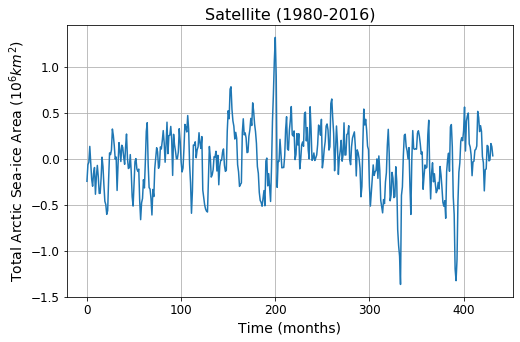

In [85]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(tot_arc_sia_sat_1980_2016/1e6)

plt.xlabel('Time (months)', fontsize=14)
plt.ylabel('Total Arctic Sea-ice Area ($10^6 km^2$)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title('Satellite (1980-2016)', fontsize=16)

Text(0.5,1,'Satellite (1980-2016)')

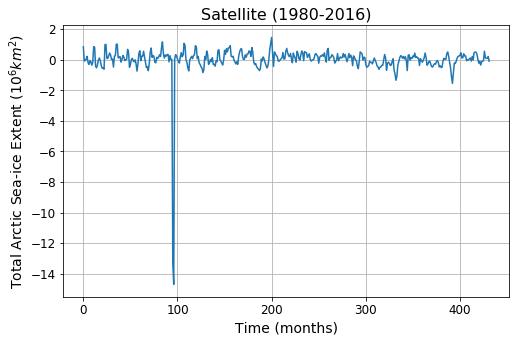

In [87]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(tot_arc_sie_sat_1980_2016/1e6)

plt.xlabel('Time (months)', fontsize=14)
plt.ylabel('Total Arctic Sea-ice Extent ($10^6 km^2$)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title('Satellite (1980-2016)', fontsize=16)

## Reanlaysis data: 

In [86]:
train_dsource = 'cesm_lme'
# train_dsource = 'era5'
# valid_dsource = 'era5'
valid_dsource = 'era5_regridlme'

In [87]:
exp_setup['train_dsource'] = train_dsource
exp_setup['valid_dsource'] = valid_dsource 

exp_setup['nyearsvalid'] = 41
exp_setup['nyearstrain'] = (yrend-850)
exp_setup['nyears_startvalid'] = 1*12
exp_setup['nyearstot'] = 1155

In [88]:
fdic = limkb.build_training_dic(exp_setup['valid_dsource'])
    
Ptrunc = {}
var_dict_era5 = {}
ntims = len(exp_setup['lags'])
print('Validation data: '+exp_setup['valid_dsource'])

tecut = int(exp_setup['nyears_startvalid']/12)+(exp_setup['nyearsvalid'])

X_var_era5, var_dict_era5 = limkb.load_data(var, var_dict_era5, fdic, 
                                  remove_climo=exp_setup['remove_climo'], 
                                  detrend=exp_setup['detrend'], verbose=verbose, 
                                  tscut=int(exp_setup['nyears_startvalid']/12), 
                                  tecut=tecut, lat_cutoff=exp_setup['lat_cutoff'][var])

Validation data: era5_regridlme
Loading from sic
Loading from ents/SeaIceData/ERA5/sic_monthly_ERA5_1979_2020_regridlme.nc
time dimension: 1980 - 2020
latitude cutoff detected: 40
detrending...
Working on month...0
Found with nans (not in satellite), going to fill with zeros...
Working on month...1
Found with nans (not in satellite), going to fill with zeros...
Working on month...2
Found with nans (not in satellite), going to fill with zeros...
Working on month...3
Found with nans (not in satellite), going to fill with zeros...
Working on month...4
Found with nans (not in satellite), going to fill with zeros...
Working on month...5
Found with nans (not in satellite), going to fill with zeros...
Working on month...6
Found with nans (not in satellite), going to fill with zeros...
Working on month...7
Found with nans (not in satellite), going to fill with zeros...
Working on month...8
Found with nans (not in satellite), going to fill with zeros...
Working on month...9
Found with nans (not

In [89]:
var_dict_full_og = {}

X_var_full_og, var_dict_full_og = limkb.load_data(var, var_dict_full_og, fdic, 
                                                  remove_climo=False, 
                                                  detrend=False, verbose=verbose, 
                                                  tscut=int(exp_setup['nyears_startvalid']/12), 
                                                  tecut=tecut, lat_cutoff=exp_setup['lat_cutoff'][var])

sie = np.where(X_var_full_og>=0.15,100,0)
ndof = sie.shape[0]
ntime = sie.shape[1]
remove_climo = exp_setup['remove_climo']

#Detrend: 
x_var_dt = np.zeros((ndof,int(ntime/12),12))
climo = np.zeros((ndof,12))
x_var_3d = np.reshape(sie, (ndof,int(ntime/12),12))
for i in range(12):
    print('Working on month...'+str(i))
    y = x_var_3d[:,:,i]
    if ('goddard' in fdic[var]) & (np.isnan(y).sum()>0):
        print('Found some nans in satellite data, going to fill with previous timestep...')
        inds = np.where(np.isnan(y))
        ind_int = int(inds[1].min()-1)
        fill = np.ones(y.shape)*y[:,ind_int][:,np.newaxis]
        var_nans_mask = np.where(np.isnan(y),np.nan,1)
        Y = np.where(np.isnan(y),fill,y)
    elif np.isnan(y).sum()>0: 
        print('Found with nans (not in satellite), going to fill with zeros...')
        var_nans_mask = np.where(np.isnan(y),np.nan,1)
        Y = np.where(np.isnan(y),0,y)
    else: 
        Y = y
#                print('Y = '+ str(Y.shape))
    X = np.arange(0,int(ntime/12))
    [var_dt,_,intercept] = statskb.multi_linear_detrend(X,Y,axis=1,atol=False,
                                                        remove_mn=remove_climo)
    if np.isnan(y).sum()>0:
        x_var_dt[:,:,i] = var_dt*var_nans_mask
    else: 
        x_var_dt[:,:,i] = var_dt
    climo[:,i] = intercept

x_var_anom = np.reshape(x_var_dt,(ndof,ntime))
sie_anom_era5 = x_var_anom

Loading from sic
Loading from ents/SeaIceData/ERA5/sic_monthly_ERA5_1979_2020_regridlme.nc
time dimension: 1980 - 2020
latitude cutoff detected: 40
-----------------------------------------------------
completed in 0.028130292892456055 seconds
-----------------------------------------------------
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11


In [90]:
full_names, areawt_name, month_names = limbuild.load_full_names()

areacell_dict_all = {}
areacell = {}
areacell_dict = {}
areacell[var], areacell_dict_all[var] = limkb.load_data(areawt_name[var], areacell_dict, fdic, 
                                                       remove_climo=False, detrend=False, verbose=False, 
                                                       lat_cutoff=exp_setup['lat_cutoff'][var])

Loading from 22/Documents/SeaIceData/CESM_LE/areacello_CESM_LE_002_tos.nc
latitude cutoff detected: 40


In [91]:
units = areacell_dict_all[var][areawt_name[var]]['units']

if 'km' in units:
    acell = areacell[var]
elif 'centi' in units: 
    print('changing cellarea units from '+
          str(areacell_dict_all[var][areawt_name[var]]['units'])+' to km^2')
    acell = areacell[var]*(1e-10)
    units = 'km^2'
else: 
    print('changing cellarea units from '+
          str(areacell_dict_all[var][areawt_name[var]]['units'])+' to km^2')
    acell = areacell[var]*(1e-6)
    units = 'km^2'

changing cellarea units from centimeter^2 to km^2


In [92]:
nlon = int(var_dict_era5[var]['var_ndof']/var_dict_era5[var]['lat'].shape[0])

tot_arc_sia_era5_1980_2020 = statskb.calc_tot_si_checks(X_var_era5,acell,units,var_dict_era5[var]['lat'],
                                                            nlon,lat_cutoff=0.0)
tot_arc_sie_era5_1980_2020 = statskb.calc_tot_si_checks(sie_anom_era5,acell,units,var_dict_era5[var]['lat'],
                                                            nlon,lat_cutoff=0.0)

Max concentration is 110.0 ...dividing concentration by 100.


Text(0.5, 1.0, 'ERA5 (1980-2020)')

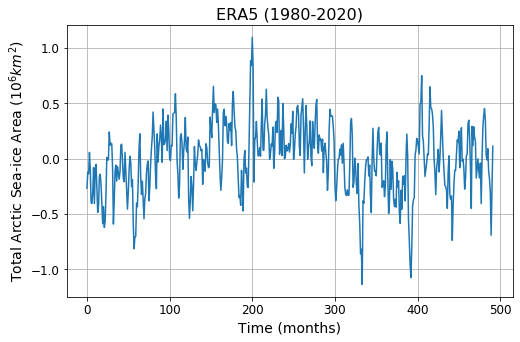

In [93]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(tot_arc_sia_era5_1980_2020/1e6)

plt.xlabel('Time (months)', fontsize=14)
plt.ylabel('Total Arctic Sea-ice Area ($10^6 km^2$)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title('ERA5 (1980-2020)', fontsize=16)

Text(0.5, 1.0, 'ERA5 (1980-2020)')

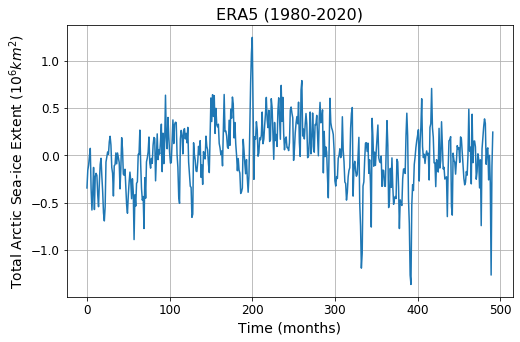

In [94]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(tot_arc_sie_era5_1980_2020/1e6)

plt.xlabel('Time (months)', fontsize=14)
plt.ylabel('Total Arctic Sea-ice Extent ($10^6 km^2$)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title('ERA5 (1980-2020)', fontsize=16)

## Calculating Seasonal Spread: 

In [78]:
tot_sia_diff_le = np.zeros(93)

for i in range(93):
    tot_sia_diff_le[i] = np.max(tot_sia_2d[i,:])-np.min(tot_sia_2d[i,:])

In [79]:
tot_sia_lme1_2d = np.reshape((tot_arc_sia_lme_851_1850/1e6),(1000,12))
tot_sia_diff_lme1 = np.zeros(1000)

for i in range(1000):
    tot_sia_diff_lme1[i] = np.max(tot_sia_lme1_2d[i,:])-np.min(tot_sia_lme1_2d[i,:])

In [80]:
tot_sia_lme2_2d = np.reshape((tot_arc_sia_lme_1851_2005/1e6),(155,12))
tot_sia_diff_lme2 = np.zeros(155)

for i in range(155):
    tot_sia_diff_lme2[i] = np.max(tot_sia_lme2_2d[i,:])-np.min(tot_sia_lme2_2d[i,:])

In [81]:
tot_sia_mpihist_2d = np.reshape((tot_arc_sia_mpi_hist_1850_2014/1e6),(164,12))
tot_sia_diff_mpihist = np.zeros(164)

for i in range(164):
    tot_sia_diff_mpihist[i] = np.max(tot_sia_mpihist_2d[i,:])-np.min(tot_sia_mpihist_2d[i,:])

In [82]:
tot_sia_diff_lme2.shape, np.arange(1851,2005,1).shape, tot_sia_diff_mpihist.shape

((155,), (154,), (164,))

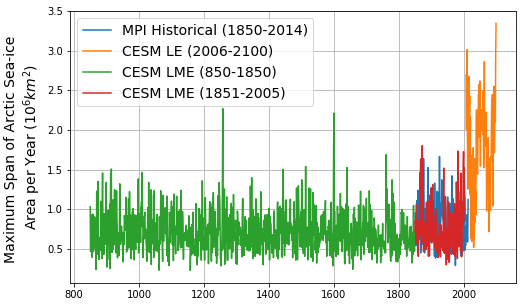

In [83]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(np.arange(1850,2014,1),tot_sia_diff_mpihist, label='MPI Historical (1850-2014)')
plt.plot(np.arange(2007,2100,1),tot_sia_diff_le, label='CESM LE (2006-2100)')
plt.plot(np.arange(850,1850,1),tot_sia_diff_lme1, label='CESM LME (850-1850)')
plt.plot(np.arange(1850,2005,1),tot_sia_diff_lme2, label='CESM LME (1851-2005)')

plt.ylabel('Maximum Span of Arctic Sea-ice \nArea per Year ($10^6 km^2$)', fontsize=14)
plt.legend(fontsize=14)

In [84]:
tot_arc_sia_le_2006_2100.shape, tot_arc_sia_mpi_hist_1850_2014.shape

((1116,), (1968,))

Text(0.5,1,'CESM LME + LE (850-2100)')

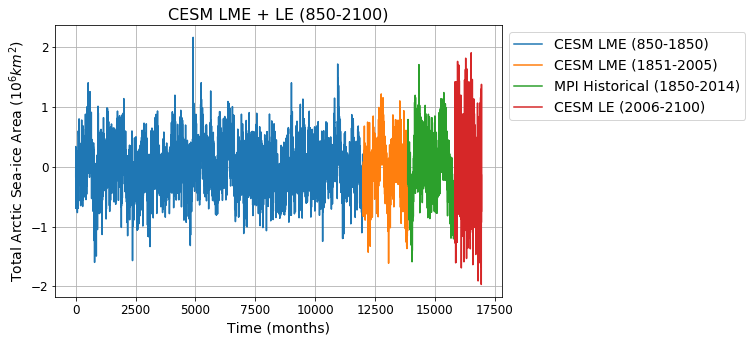

In [85]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(np.arange(0,12000,1),tot_arc_sia_lme_851_1850/1e6, label='CESM LME (850-1850)')
plt.plot(np.arange(12001,12001+1860,1),tot_arc_sia_lme_1851_2005/1e6, label='CESM LME (1851-2005)')
plt.plot(np.arange(12001+1861,12001+1861+1968,1),tot_arc_sia_mpi_hist_1850_2014/1e6, label='MPI Historical (1850-2014)')
plt.plot(np.arange(12001+1861+1969,12001+1861+1969+1116,1),tot_arc_sia_le_2006_2100/1e6, label='CESM LE (2006-2100)')
plt.plot(chunk_mn/1e6)

plt.xlabel('Time (months)', fontsize=14)
plt.ylabel('Total Arctic Sea-ice Area ($10^6 km^2$)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(bbox_to_anchor=[1,1],fontsize=14)

plt.title('CESM LME + LE (850-2100)', fontsize=16)

Text(0.5,1,'CESM LME + LE (850-2100)')

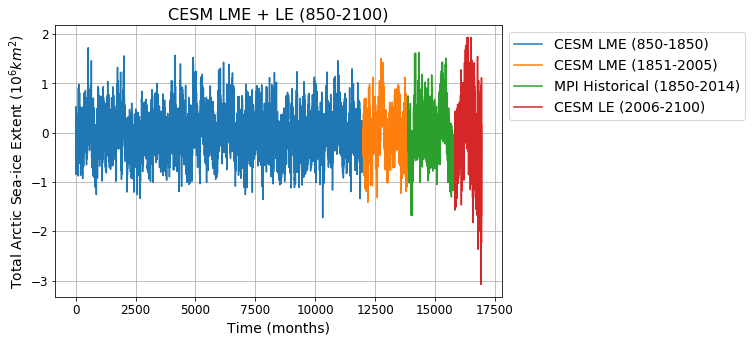

In [86]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.grid(axis='both')

plt.plot(np.arange(0,12000,1),tot_arc_sie_lme_851_1850/1e6, label='CESM LME (850-1850)')
plt.plot(np.arange(12001,12001+1860,1),tot_arc_sie_lme_1851_2005/1e6, label='CESM LME (1851-2005)')
plt.plot(np.arange(12001+1861,12001+1861+1968,1),tot_arc_sie_mpi_hist_1850_2014/1e6, label='MPI Historical (1850-2014)')
plt.plot(np.arange(12001+1861+1969,12001+1861+1969+1116,1),tot_arc_sie_le_2006_2100/1e6, label='CESM LE (2006-2100)')
plt.plot(chunk_mn/1e6)

plt.xlabel('Time (months)', fontsize=14)
plt.ylabel('Total Arctic Sea-ice Extent ($10^6 km^2$)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(bbox_to_anchor=[1,1],fontsize=14)

plt.title('CESM LME + LE (850-2100)', fontsize=16)

In [91]:
print('CESM LME (851-1850)          = '+str(np.std(tot_arc_sia_lme_851_1850/1e6)))
print('CESM LME (1851-2005)         = '+str(np.std(tot_arc_sia_lme_1851_2005/1e6)))
print('CESM2 Historical (1851-2014) = '+str(np.std(tot_arc_sia_cesm2_hist_1850_2014/1e6)))
print('MPI Historical (1850-2014)   = '+str(np.std(tot_arc_sia_mpi_hist_1850_2014/1e6)))
print('Satellite (1980-2016)        = '+str(np.std(tot_arc_sia_sat_1980_2016/1e6)))
print('ERA5 (1980-2020)             = '+str(np.std(tot_arc_sia_era5_1980_2020/1e6)))
print('CESM LE (2006-2100)          = '+str(np.std(tot_arc_sia_le_2006_2100/1e6)))

CESM LME (851-1850)          = 0.36124815073603256
CESM LME (1851-2005)         = 0.42207290318395707
CESM2 Historical (1851-2014) = 0.5251124400462174
MPI Historical (1850-2014)   = 0.4610769635816368
Satellite (1980-2016)        = 0.33434662278515587
ERA5 (1980-2020)             = 0.30964804547774305
CESM LE (2006-2100)          = 0.6245792867987735


In [90]:
print('CESM LME (851-1850)          = '+str(np.std(tot_arc_sie_lme_851_1850/1e6)))
print('CESM LME (1851-2005)         = '+str(np.std(tot_arc_sie_lme_1851_2005/1e6)))
print('CESM2 Historical (1851-2014) = '+str(np.std(tot_arc_sie_cesm2_hist_1850_2014/1e6)))
print('MPI Historical (1850-2014)   = '+str(np.std(tot_arc_sie_mpi_hist_1850_2014/1e6)))
print('Satellite (1980-2016)        = '+str(np.std(tot_arc_sie_sat_1980_2016/1e6)))
print('ERA5 (1980-2020)             = '+str(np.std(tot_arc_sie_era5_1980_2020/1e6)))
print('CESM LE (2006-2100)          = '+str(np.std(tot_arc_sie_le_2006_2100/1e6)))

CESM LME (851-1850)          = 0.4116397122613094
CESM LME (1851-2005)         = 0.4455550723783371
CESM2 Historical (1851-2014) = 0.4276703405974902
MPI Historical (1850-2014)   = 0.5279871962677813
Satellite (1980-2016)        = 1.009892015531277
ERA5 (1980-2020)             = 0.33377206006050203
CESM LE (2006-2100)          = 0.6080862458604459


In [168]:
tot_arc_sia = {}

tot_arc_sia['CESM_LME_851_1850'] = tot_arc_sia_lme_851_1850/1e6
tot_arc_sia['CESM_LME_1851_2005'] = tot_arc_sia_lme_1851_2005/1e6
tot_arc_sia['CESM2_Hist_1850_2014'] = tot_arc_sia_cesm2_hist_1850_2014/1e6
tot_arc_sia['GFDL_Hist_1850_2014'] = tot_arc_sia_gfdl_hist_1850_2014/1e6
tot_arc_sia['MPI_Hist_1850_2014'] = tot_arc_sia_mpi_hist_1850_2014/1e6
tot_arc_sia['Satellite_1980_2016'] = tot_arc_sia_sat_1980_2016/1e6
tot_arc_sia['ERA5_1980_2020'] = tot_arc_sia_era5_1980_2020/1e6
tot_arc_sia['CESM_LE_2006_2100'] = tot_arc_sia_le_2006_2100/1e6

In [169]:
savename = 'Total_Arctic_SIA_CESMlme_MPIhist_SAT_ERA5_CESMle_CESM2_GFDL.pkl'
pickle.dump(tot_arc_sia, open(savename, "wb" ) )

In [170]:
tot_arc_sie = {}

tot_arc_sie['CESM_LME_851_1850'] = tot_arc_sie_lme_851_1850/1e6
tot_arc_sie['CESM_LME_1851_2005'] = tot_arc_sie_lme_1851_2005/1e6
tot_arc_sie['CESM2_Hist_1850_2014'] = tot_arc_sie_cesm2_hist_1850_2014/1e6
tot_arc_sie['GFDL_Hist_1850_2014'] = tot_arc_sie_gfdl_hist_1850_2014/1e6
tot_arc_sie['MPI_Hist_1850_2014'] = tot_arc_sie_mpi_hist_1850_2014/1e6
tot_arc_sie['Satellite_1980_2016'] = tot_arc_sie_sat_1980_2016/1e6
tot_arc_sie['ERA5_1980_2020'] = tot_arc_sie_era5_1980_2020/1e6
tot_arc_sie['CESM_LE_2006_2100'] = tot_arc_sie_le_2006_2100/1e6

In [171]:
savename = 'Total_Arctic_SIE_CESMlme_MPIhist_SAT_ERA5_CESMle_CESM2_GFDL.pkl'
pickle.dump(tot_arc_sie, open(savename, "wb" ) )

In [212]:
np.nanmin(X_var_era5), np.nanmax(X_var_era5)

(-0.9304448667058738, 0.8886525315350121)

In [156]:
X_var_mpi_hist.shape

(28160, 1968)

## Spatial variance : 

In [177]:
train_mnstate = np.reshape(np.var(X_var_train[:,0:800*12],axis=1),(96,320))
era5_mnstate = np.reshape(np.var(X_var_era5*100,axis=1),(96,320))
sat_mnstate = np.reshape(np.nanvar(X_var_sat*100,axis=1),(96,320))

le_mnstate = np.reshape(np.var(X_var_le[:,0:50*12],axis=1),(96,320))

lme1_mnstate = np.reshape(np.var(X_var_lme_hist[:,12:50*12],axis=1),(96,320))
lme2_mnstate = np.reshape(np.var(X_var_lme_hist[:,51*12:100*12],axis=1),(96,320))
lme3_mnstate = np.reshape(np.var(X_var_lme_hist[:,101*12:155*12],axis=1),(96,320))

ccsm4_lm_mnstate = np.reshape(np.var(X_var_ccsm4_lm,axis=1),(96,320))

mpi_lm1_mnstate = np.reshape(np.var(X_var_mpi_lm[:,0:200],axis=1),(96,320))
mpi_lm2_mnstate = np.reshape(np.var(X_var_mpi_lm[:,200:400],axis=1),(96,320))
mpi_lm3_mnstate = np.reshape(np.var(X_var_mpi_lm[:,400:600],axis=1),(96,320))
mpi_lm_mnstate = np.reshape(np.var(X_var_mpi_lm,axis=1),(96,320))
#mpi_lm_mnstate2 = np.reshape(np.var(X_var_mpi_lm2,axis=1),(96,320))

cesm2_hist1_mnstate = np.reshape(np.var(X_var_cesm2_hist[:,12:50*12],axis=1),(96,320))
cesm2_hist2_mnstate = np.reshape(np.var(X_var_cesm2_hist[:,51*12:100*12],axis=1),(96,320))
cesm2_hist3_mnstate = np.reshape(np.var(X_var_cesm2_hist[:,101*12:164*12],axis=1),(96,320))
cesm2_hist_mnstate = np.reshape(np.var(X_var_cesm2_hist,axis=1),(96,320))

mpi_hist1_mnstate = np.reshape(np.var(X_var_mpi_hist[:,12:50*12],axis=1),(96,320))
mpi_hist2_mnstate = np.reshape(np.var(X_var_mpi_hist[:,51*12:100*12],axis=1),(96,320))
mpi_hist3_mnstate = np.reshape(np.var(X_var_mpi_hist[:,101*12:164*12],axis=1),(96,320))
mpi_hist_mnstate = np.reshape(np.var(X_var_mpi_hist,axis=1),(96,320))

gfdl_hist1_mnstate = np.reshape(np.var(X_var_gfdl_hist[:,12:50*12],axis=1),(96,320))
gfdl_hist2_mnstate = np.reshape(np.var(X_var_gfdl_hist[:,51*12:100*12],axis=1),(96,320))
gfdl_hist3_mnstate = np.reshape(np.var(X_var_gfdl_hist[:,101*12:164*12],axis=1),(96,320))
gfdl_hist_mnstate = np.reshape(np.var(X_var_gfdl_hist,axis=1),(96,320))

canESM_hist1_mnstate = np.reshape(np.var(X_var_canESM_hist[:,12:50*12],axis=1),(96,320))
canESM_hist2_mnstate = np.reshape(np.var(X_var_canESM_hist[:,51*12:100*12],axis=1),(96,320))
canESM_hist3_mnstate = np.reshape(np.var(X_var_canESM_hist[:,101*12:164*12],axis=1),(96,320))
canESM_hist_mnstate = np.reshape(np.var(X_var_canESM_hist,axis=1),(96,320))

hadGEM3_hist1_mnstate = np.reshape(np.var(X_var_hadGEM3_hist[:,12:50*12],axis=1),(96,320))
hadGEM3_hist2_mnstate = np.reshape(np.var(X_var_hadGEM3_hist[:,51*12:100*12],axis=1),(96,320))
hadGEM3_hist3_mnstate = np.reshape(np.var(X_var_hadGEM3_hist[:,101*12:164*12],axis=1),(96,320))
hadGEM3_hist_mnstate = np.reshape(np.var(X_var_hadGEM3_hist,axis=1),(96,320))

In [33]:
mpi_lm_mnstate2 = np.reshape(np.var(X_var_mpi_lm2,axis=1),(110,256))
train_mnstate = np.reshape(np.var(X_var_train[:,0:800*12],axis=1),(96,320))

In [98]:
ccsm4_lm_mnstate = np.reshape(np.var(X_var_ccsm4_lm,axis=1),(96,320))
mpi_lm_mnstate = np.reshape(np.var(X_var_mpi_lm,axis=1),(96,320))
scor_train_mpi_lm = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),np.nan_to_num(mpi_lm_mnstate.flatten()))[0,1]
scor_train_ccsm4_lm = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),np.nan_to_num(ccsm4_lm_mnstate.flatten()))[0,1]

ccsm4_mnstate = {}
scor_train_ccsm4 = {}

mpi_lm_all_mnstate = {}
scor_train_mpi_lm_all = {}

startyr_list = [1,100,200,300,400,500,600,700,800,900]

for i,startyr in enumerate(startyr_list):
    ccsm4_mnstate[startyr] = np.reshape(np.var(X_var_ccsm4_lm[:,startyr:startyr+99],axis=1),(96,320))
    scor_train_ccsm4[startyr] = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),
                                            np.nan_to_num(ccsm4_mnstate[startyr].flatten()))[0,1]
    
    mpi_lm_all_mnstate[startyr] = np.reshape(np.var(X_var_mpi_lm[:,startyr:startyr+99],axis=1),(96,320))
    scor_train_mpi_lm_all[startyr] = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),
                                                 np.nan_to_num(mpi_lm_all_mnstate[startyr].flatten()))[0,1]

In [195]:
scor_train_le = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),np.nan_to_num(le_mnstate.flatten()))[0,1]
scor_train_era5 = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),np.nan_to_num(era5_mnstate.flatten()))[0,1]
scor_era5_sat = np.corrcoef(np.nan_to_num(sat_mnstate.flatten()),np.nan_to_num(era5_mnstate.flatten()))[0,1]
scor_train_sat = np.corrcoef(np.nan_to_num(sat_mnstate.flatten()),np.nan_to_num(train_mnstate.flatten()))[0,1]

scor_lme3_sat = np.corrcoef(np.nan_to_num(sat_mnstate.flatten()),np.nan_to_num(lme3_mnstate.flatten()))[0,1]
scor_le_sat = np.corrcoef(np.nan_to_num(sat_mnstate.flatten()),np.nan_to_num(le_mnstate.flatten()))[0,1]
scor_cesm2_sat = np.corrcoef(np.nan_to_num(sat_mnstate.flatten()),np.nan_to_num(cesm2_hist_mnstate.flatten()))[0,1]
scor_gfdl_sat = np.corrcoef(np.nan_to_num(sat_mnstate.flatten()),np.nan_to_num(gfdl_hist_mnstate.flatten()))[0,1]
scor_mpi_sat = np.corrcoef(np.nan_to_num(sat_mnstate.flatten()),np.nan_to_num(mpi_hist_mnstate.flatten()))[0,1]
scor_canESM_sat = np.corrcoef(np.nan_to_num(sat_mnstate.flatten()),np.nan_to_num(canESM_hist_mnstate.flatten()))[0,1]
scor_hadGEM3_sat = np.corrcoef(np.nan_to_num(sat_mnstate.flatten()),np.nan_to_num(hadGEM3_hist_mnstate.flatten()))[0,1]
scor_ccsm4lm_sat = np.corrcoef(np.nan_to_num(sat_mnstate.flatten()),np.nan_to_num(ccsm4_lm_mnstate.flatten()))[0,1]
scor_mpilm_sat = np.corrcoef(np.nan_to_num(sat_mnstate.flatten()),np.nan_to_num(mpi_lm_mnstate.flatten()))[0,1]

scor_cesm2_era5 = np.corrcoef(np.nan_to_num(era5_mnstate.flatten()),np.nan_to_num(cesm2_hist_mnstate.flatten()))[0,1]
scor_gfdl_era5 = np.corrcoef(np.nan_to_num(era5_mnstate.flatten()),np.nan_to_num(gfdl_hist_mnstate.flatten()))[0,1]
scor_mpi_era5 = np.corrcoef(np.nan_to_num(era5_mnstate.flatten()),np.nan_to_num(mpi_hist_mnstate.flatten()))[0,1]
scor_canESM_era5 = np.corrcoef(np.nan_to_num(era5_mnstate.flatten()),np.nan_to_num(canESM_hist_mnstate.flatten()))[0,1]
scor_hadGEM3_era5 = np.corrcoef(np.nan_to_num(era5_mnstate.flatten()),np.nan_to_num(hadGEM3_hist_mnstate.flatten()))[0,1]

scor_train_ccsm4_lm = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),np.nan_to_num(ccsm4_lm_mnstate.flatten()))[0,1]
scor_train_mpi_lm = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),np.nan_to_num(mpi_lm_mnstate.flatten()))[0,1]

scor_train_lme1 = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),np.nan_to_num(lme1_mnstate.flatten()))[0,1]
scor_train_lme2 = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),np.nan_to_num(lme2_mnstate.flatten()))[0,1]
scor_train_lme3 = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),np.nan_to_num(lme3_mnstate.flatten()))[0,1]

scor_train_cesm2_hist1 = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),
                                    np.nan_to_num(cesm2_hist1_mnstate.flatten()))[0,1]
scor_train_cesm2_hist2 = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),
                                    np.nan_to_num(cesm2_hist2_mnstate.flatten()))[0,1]
scor_train_cesm2_hist3 = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),
                                    np.nan_to_num(cesm2_hist3_mnstate.flatten()))[0,1]
scor_train_cesm2_hist = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),
                                    np.nan_to_num(cesm2_hist_mnstate.flatten()))[0,1]

scor_train_gfdl_hist1 = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),
                                    np.nan_to_num(gfdl_hist1_mnstate.flatten()))[0,1]
scor_train_gfdl_hist2 = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),
                                    np.nan_to_num(gfdl_hist2_mnstate.flatten()))[0,1]
scor_train_gfdl_hist3 = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),
                                    np.nan_to_num(gfdl_hist3_mnstate.flatten()))[0,1]
scor_train_gfdl_hist = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),
                                    np.nan_to_num(gfdl_hist_mnstate.flatten()))[0,1]

scor_train_mpi_hist1 = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),
                                    np.nan_to_num(mpi_hist1_mnstate.flatten()))[0,1]
scor_train_mpi_hist2 = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),
                                    np.nan_to_num(mpi_hist2_mnstate.flatten()))[0,1]
scor_train_mpi_hist3 = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),
                                    np.nan_to_num(mpi_hist3_mnstate.flatten()))[0,1]
scor_train_mpi_hist = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),
                                    np.nan_to_num(mpi_hist_mnstate.flatten()))[0,1]

In [178]:
scor_train_canESM_hist1 = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),
                                    np.nan_to_num(canESM_hist1_mnstate.flatten()))[0,1]
scor_train_canESM_hist2 = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),
                                    np.nan_to_num(canESM_hist2_mnstate.flatten()))[0,1]
scor_train_canESM_hist3 = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),
                                    np.nan_to_num(canESM_hist3_mnstate.flatten()))[0,1]
scor_train_canESM_hist = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),
                                    np.nan_to_num(canESM_hist_mnstate.flatten()))[0,1]

scor_train_hadGEM3_hist1 = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),
                                    np.nan_to_num(hadGEM3_hist1_mnstate.flatten()))[0,1]
scor_train_hadGEM3_hist2 = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),
                                    np.nan_to_num(hadGEM3_hist2_mnstate.flatten()))[0,1]
scor_train_hadGEM3_hist3 = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),
                                    np.nan_to_num(hadGEM3_hist3_mnstate.flatten()))[0,1]
scor_train_hadGEM3_hist = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),
                                    np.nan_to_num(hadGEM3_hist_mnstate.flatten()))[0,1]

In [155]:
spatial_correlation = {}

spatial_correlation['scor_train_le'] = scor_train_le
spatial_correlation['scor_train_era5'] = scor_train_era5
spatial_correlation['scor_train_sat'] = scor_train_sat

spatial_correlation['scor_lme3_sat'] = scor_lme3_sat
spatial_correlation['scor_le_sat'] = scor_le_sat
spatial_correlation['scor_cesm2_sat'] = scor_cesm2_sat
spatial_correlation['scor_gfdl_sat'] = scor_gfdl_sat
spatial_correlation['scor_mpi_sat'] = scor_mpi_sat
spatial_correlation['scor_mpilm_sat'] = scor_mpilm_sat
spatial_correlation['scor_ccsm4lm_sat'] = scor_ccsm4lm_sat

spatial_correlation['scor_train_mpi_lm'] = scor_train_mpi_lm
spatial_correlation['scor_train_mpi_lm_all'] = scor_train_mpi_lm_all
spatial_correlation['scor_train_ccsm4_lm'] = scor_train_ccsm4_lm
spatial_correlation['scor_train_ccsm4_lm_all'] = scor_train_ccsm4

spatial_correlation['scor_train_lme1'] = scor_train_lme1
spatial_correlation['scor_train_lme2'] = scor_train_lme2
spatial_correlation['scor_train_lme3'] = scor_train_lme3

spatial_correlation['scor_train_cesm2_hist1'] = scor_train_cesm2_hist1
spatial_correlation['scor_train_cesm2_hist2'] = scor_train_cesm2_hist2
spatial_correlation['scor_train_cesm2_hist3'] = scor_train_cesm2_hist3
spatial_correlation['scor_train_cesm2_hist'] = scor_train_cesm2_hist

spatial_correlation['scor_train_gfdl_hist1'] = scor_train_gfdl_hist1
spatial_correlation['scor_train_gfdl_hist2'] = scor_train_gfdl_hist2
spatial_correlation['scor_train_gfdl_hist3'] = scor_train_gfdl_hist3
spatial_correlation['scor_train_gfdl_hist'] = scor_train_gfdl_hist

spatial_correlation['scor_train_mpi_hist1'] = scor_train_mpi_hist1
spatial_correlation['scor_train_mpi_hist2'] = scor_train_mpi_hist2
spatial_correlation['scor_train_mpi_hist3'] = scor_train_mpi_hist3
spatial_correlation['scor_train_mpi_hist'] = scor_train_mpi_hist

In [179]:
spatial_correlation['scor_train_canESM_hist1'] = scor_train_canESM_hist1
spatial_correlation['scor_train_canESM_hist2'] = scor_train_canESM_hist2
spatial_correlation['scor_train_canESM_hist3'] = scor_train_canESM_hist3
spatial_correlation['scor_train_canESM_hist'] = scor_train_canESM_hist

spatial_correlation['scor_train_hadGEM3_hist1'] = scor_train_hadGEM3_hist1
spatial_correlation['scor_train_hadGEM3_hist2'] = scor_train_hadGEM3_hist2
spatial_correlation['scor_train_hadGEM3_hist3'] = scor_train_hadGEM3_hist3
spatial_correlation['scor_train_hadGEM3_hist'] = scor_train_hadGEM3_hist

In [180]:
print('R (Training, ERA5 (1980-2020))       = '+ str(scor_train_era5))
print('R (Training, SAT (1980-2016))        = '+ str(scor_train_sat))
print('')
print('R (Training, CCSM4 LM (851-1849))    = '+ str(scor_train_ccsm4_lm))
print('R (Training, MPI LM (851-1849))      = '+ str(scor_train_mpi_lm))
print('')
print('R (Training, CESM1 LME (1851-1900))  = '+ str(scor_train_lme1))
print('R (Training, CESM1 LME (1901-1950))  = '+ str(scor_train_lme2))
print('R (Training, CESM1 LME (1951-2004))  = '+ str(scor_train_lme3))
print('')
print('R (Training, CESM2 hist (1851-1900)) = '+ str(scor_train_cesm2_hist1))
print('R (Training, CESM2 hist (1901-1950)) = '+ str(scor_train_cesm2_hist2))
print('R (Training, CESM2 hist (1951-2014)) = '+ str(scor_train_cesm2_hist3))
print('')
print('R (Training, GFDL hist (1851-1900))  = '+ str(scor_train_gfdl_hist1))
print('R (Training, GFDL hist (1901-1950))  = '+ str(scor_train_gfdl_hist2))
print('R (Training, GFDL hist (1951-2014))  = '+ str(scor_train_gfdl_hist3))
print('')
print('R (Training, MPI hist (1851-1900))   = '+ str(scor_train_mpi_hist1))
print('R (Training, MPI hist (1901-1950))   = '+ str(scor_train_mpi_hist2))
print('R (Training, MPI hist (1951-2014))   = '+ str(scor_train_mpi_hist3))
print('')
print('R (Training, HadGEM3 hist (1851-1900))   = '+ str(scor_train_hadGEM3_hist1))
print('R (Training, HadGEM3 hist (1901-1950))   = '+ str(scor_train_hadGEM3_hist2))
print('R (Training, HadGEM3 hist (1951-2014))   = '+ str(scor_train_hadGEM3_hist3))
print('')
print('R (Training, CanESM hist (1851-1900))   = '+ str(scor_train_canESM_hist1))
print('R (Training, CanESM hist (1901-1950))   = '+ str(scor_train_canESM_hist2))
print('R (Training, CanESM hist (1951-2014))   = '+ str(scor_train_canESM_hist3))
print('')
print('R (Training, CESM1 LE (2007-2057))   = '+ str(scor_train_le))

R (Training, ERA5 (1980-2020))       = 0.4622404964005686
R (Training, SAT (1980-2016))        = 0.5298436289977722

R (Training, CCSM4 LM (851-1849))    = 0.8832034281798729
R (Training, MPI LM (851-1849))      = 0.609216717826204

R (Training, CESM1 LME (1851-1900))  = 0.9773999667533252
R (Training, CESM1 LME (1901-1950))  = 0.9771586831278339
R (Training, CESM1 LME (1951-2004))  = 0.9734668482745135

R (Training, CESM2 hist (1851-1900)) = 0.7865500312468631
R (Training, CESM2 hist (1901-1950)) = 0.7858793884585992
R (Training, CESM2 hist (1951-2014)) = 0.7667726277499384

R (Training, GFDL hist (1851-1900))  = 0.629716932588565
R (Training, GFDL hist (1901-1950))  = 0.5627234762404515
R (Training, GFDL hist (1951-2014))  = 0.6739770301596524

R (Training, MPI hist (1851-1900))   = 0.5795545652624956
R (Training, MPI hist (1901-1950))   = 0.5387167317671295
R (Training, MPI hist (1951-2014))   = 0.4812137479618758

R (Training, HadGEM3 hist (1851-1900))   = 0.7580051999958454
R (Tra

In [139]:
print('R (Training, ERA5 (1980-2020))       = '+ str(scor_train_era5))
print('R (Training, SAT (1980-2016))        = '+ str(scor_train_sat))
print('R (ERA5, SAT (1980-2016))            = '+ str(scor_era5_sat))
print('')
print('R (CESM LME (1951-2004), SAT)        = '+ str(scor_lme3_sat))
print('R (CESM LE , SAT (1980-2016))        = '+ str(scor_le_sat))
print('R (GFDL Historical, SAT (1980-2016)) = '+ str(scor_gfdl_sat))
print('R (CESM2 Historical, SAT (1980-2016))= '+ str(scor_cesm2_sat))
print('R (MPI Historical, SAT (1980-2016))  = '+ str(scor_mpi_sat))
print('R (MPI LM, SAT (1980-2016))          = '+ str(scor_mpilm_sat))
print('R (CCSM4 LM, SAT (1980-2016))        = '+ str(scor_ccsm4lm_sat))

R (Training, ERA5 (1980-2020))       = 0.4622404964005686
R (Training, SAT (1980-2016))        = 0.5298436289977722
R (ERA5, SAT (1980-2016))            = 0.9503407852005711

R (CESM LME (1951-2004), SAT)        = 0.5944579313132378
R (CESM LE , SAT (1980-2016))        = 0.6862469499025776
R (GFDL Historical, SAT (1980-2016)) = 0.7306543535046578
R (CESM2 Historical, SAT (1980-2016))= 0.6887218908109037
R (MPI Historical, SAT (1980-2016))  = 0.7458441076309663
R (MPI LM, SAT (1980-2016))          = 0.8023889608242154
R (CCSM4 LM, SAT (1980-2016))        = 0.5124304643048359


In [181]:
savename = 'Spatial_correlation_sic_variance_CESMlme_ERA5_CESMle_CESM2_GFDL.pkl'
pickle.dump(spatial_correlation, open(savename, "wb" ) )

## Satellite and CESM LME: 

In [131]:
# satellite data: 1980-2015: 
sat_mnstate = np.reshape(np.nanvar(X_var_sat*100,axis=1),(96,320))
sat_mnstate1 = np.reshape(np.nanvar(X_var_sat[:,0:20*12]*100,axis=1),(96,320))
sat_mnstate2 = np.reshape(np.nanvar(X_var_sat[:,21*12:]*100,axis=1),(96,320))
sat_mnstate3 = np.reshape(np.nanvar(X_var_sat[:,0:30*12]*100,axis=1),(96,320))

In [132]:
scor_train_sat = np.corrcoef(np.nan_to_num(sat_mnstate.flatten()),np.nan_to_num(train_mnstate.flatten()))[0,1]
scor_train_sat1 = np.corrcoef(np.nan_to_num(sat_mnstate1.flatten()),np.nan_to_num(train_mnstate.flatten()))[0,1]
scor_train_sat2 = np.corrcoef(np.nan_to_num(sat_mnstate2.flatten()),np.nan_to_num(train_mnstate.flatten()))[0,1]
scor_train_sat3 = np.corrcoef(np.nan_to_num(sat_mnstate3.flatten()),np.nan_to_num(train_mnstate.flatten()))[0,1]

In [133]:
print('R (Training, SAT (1980-2016)) = '+ str(scor_train_sat))
print('R (Training, SAT (1980-2000)) = '+ str(scor_train_sat1))
print('R (Training, SAT (2001-2015)) = '+ str(scor_train_sat2))
print('R (Training, SAT (1980-2010)) = '+ str(scor_train_sat3))

R (Training, SAT (1980-2016)) = 0.5298436289977722
R (Training, SAT (1980-2000)) = 0.5691655524811068
R (Training, SAT (2001-2015)) = 0.418180638050448
R (Training, SAT (1980-2010)) = 0.5474122868170989


### Calculate multi-model values: 

In [181]:
X_var_cesm2_hist.shape, X_var_mpi_hist.shape, X_var_gfdl_hist.shape

((30720, 1968), (30720, 1968), (30720, 1968))

In [198]:
X_var_multimod.shape[1]/12

656.0

In [191]:
X_var_multimod = np.concatenate((X_var_cesm2_hist, X_var_mpi_hist, X_var_gfdl_hist, 
                                 X_var_hadGEM3_hist), axis=1)

multimod_hist_mnstate = np.reshape(np.var(X_var_multimod,axis=1),(96,320))

In [192]:
scor_multimod_le = np.corrcoef(np.nan_to_num(multimod_hist_mnstate.flatten()),np.nan_to_num(le_mnstate.flatten()))[0,1]
scor_multimod_era5 = np.corrcoef(np.nan_to_num(multimod_hist_mnstate.flatten()),np.nan_to_num(era5_mnstate.flatten()))[0,1]
scor_multimod_sat = np.corrcoef(np.nan_to_num(sat_mnstate.flatten()),np.nan_to_num(multimod_hist_mnstate.flatten()))[0,1]

scor_multimod_lme1 = np.corrcoef(np.nan_to_num(multimod_hist_mnstate.flatten()),np.nan_to_num(lme1_mnstate.flatten()))[0,1]
scor_multimod_lme2 = np.corrcoef(np.nan_to_num(multimod_hist_mnstate.flatten()),np.nan_to_num(lme2_mnstate.flatten()))[0,1]
scor_multimod_lme3 = np.corrcoef(np.nan_to_num(multimod_hist_mnstate.flatten()),np.nan_to_num(lme3_mnstate.flatten()))[0,1]

scor_multimod_cesm2_hist1 = np.corrcoef(np.nan_to_num(multimod_hist_mnstate.flatten()),
                                    np.nan_to_num(cesm2_hist1_mnstate.flatten()))[0,1]
scor_multimod_cesm2_hist2 = np.corrcoef(np.nan_to_num(multimod_hist_mnstate.flatten()),
                                    np.nan_to_num(cesm2_hist2_mnstate.flatten()))[0,1]
scor_multimod_cesm2_hist3 = np.corrcoef(np.nan_to_num(multimod_hist_mnstate.flatten()),
                                    np.nan_to_num(cesm2_hist3_mnstate.flatten()))[0,1]
scor_multimod_cesm2_hist = np.corrcoef(np.nan_to_num(multimod_hist_mnstate.flatten()),
                                    np.nan_to_num(cesm2_hist_mnstate.flatten()))[0,1]

scor_multimod_gfdl_hist1 = np.corrcoef(np.nan_to_num(multimod_hist_mnstate.flatten()),
                                    np.nan_to_num(gfdl_hist1_mnstate.flatten()))[0,1]
scor_multimod_gfdl_hist2 = np.corrcoef(np.nan_to_num(multimod_hist_mnstate.flatten()),
                                    np.nan_to_num(gfdl_hist2_mnstate.flatten()))[0,1]
scor_multimod_gfdl_hist3 = np.corrcoef(np.nan_to_num(multimod_hist_mnstate.flatten()),
                                    np.nan_to_num(gfdl_hist3_mnstate.flatten()))[0,1]
scor_multimod_gfdl_hist = np.corrcoef(np.nan_to_num(multimod_hist_mnstate.flatten()),
                                    np.nan_to_num(gfdl_hist_mnstate.flatten()))[0,1]

scor_multimod_mpi_hist1 = np.corrcoef(np.nan_to_num(multimod_hist_mnstate.flatten()),
                                    np.nan_to_num(mpi_hist1_mnstate.flatten()))[0,1]
scor_multimod_mpi_hist2 = np.corrcoef(np.nan_to_num(multimod_hist_mnstate.flatten()),
                                    np.nan_to_num(mpi_hist2_mnstate.flatten()))[0,1]
scor_multimod_mpi_hist3 = np.corrcoef(np.nan_to_num(multimod_hist_mnstate.flatten()),
                                    np.nan_to_num(mpi_hist3_mnstate.flatten()))[0,1]
scor_multimod_mpi_hist = np.corrcoef(np.nan_to_num(multimod_hist_mnstate.flatten()),
                                    np.nan_to_num(mpi_hist_mnstate.flatten()))[0,1]

scor_multimod_hadGEM3_hist1 = np.corrcoef(np.nan_to_num(multimod_hist_mnstate.flatten()),
                                          np.nan_to_num(hadGEM3_hist1_mnstate.flatten()))[0,1]
scor_multimod_hadGEM3_hist2 = np.corrcoef(np.nan_to_num(multimod_hist_mnstate.flatten()),
                                          np.nan_to_num(hadGEM3_hist2_mnstate.flatten()))[0,1]
scor_multimod_hadGEM3_hist3 = np.corrcoef(np.nan_to_num(multimod_hist_mnstate.flatten()),
                                          np.nan_to_num(hadGEM3_hist3_mnstate.flatten()))[0,1]
scor_multimod_hadGEM3_hist = np.corrcoef(np.nan_to_num(multimod_hist_mnstate.flatten()),
                                         np.nan_to_num(hadGEM3_hist_mnstate.flatten()))[0,1]

scor_multimod_canESM_hist1 = np.corrcoef(np.nan_to_num(multimod_hist_mnstate.flatten()),
                                         np.nan_to_num(canESM_hist1_mnstate.flatten()))[0,1]
scor_multimod_canESM_hist2 = np.corrcoef(np.nan_to_num(multimod_hist_mnstate.flatten()),
                                         np.nan_to_num(canESM_hist2_mnstate.flatten()))[0,1]
scor_multimod_canESM_hist3 = np.corrcoef(np.nan_to_num(multimod_hist_mnstate.flatten()),
                                         np.nan_to_num(canESM_hist3_mnstate.flatten()))[0,1]
scor_multimod_canESM_hist = np.corrcoef(np.nan_to_num(multimod_hist_mnstate.flatten()),
                                        np.nan_to_num(canESM_hist_mnstate.flatten()))[0,1]

In [193]:
print('R (Multimodel, ERA5 (1980-2020))         = '+ str(scor_multimod_era5))
print('R (Multimodel, SAT (1980-2016))          = '+ str(scor_multimod_sat))
print('')
print('R (Multimodel, CESM1 LME (1851-1900))    = '+ str(scor_multimod_lme1))
print('R (Multimodel, CESM1 LME (1901-1950))    = '+ str(scor_multimod_lme2))
print('R (Multimodel, CESM1 LME (1951-2004))    = '+ str(scor_multimod_lme3))
print('')
print('R (Multimodel, CESM2 hist (1851-1900))   = '+ str(scor_multimod_cesm2_hist1))
print('R (Multimodel, CESM2 hist (1901-1950))   = '+ str(scor_multimod_cesm2_hist2))
print('R (Multimodel, CESM2 hist (1951-2014))   = '+ str(scor_multimod_cesm2_hist3))
print('')
print('R (Multimodel, GFDL hist (1851-1900))    = '+ str(scor_multimod_gfdl_hist1))
print('R (Multimodel, GFDL hist (1901-1950))    = '+ str(scor_multimod_gfdl_hist2))
print('R (Multimodel, GFDL hist (1951-2014))    = '+ str(scor_multimod_gfdl_hist3))
print('')
print('R (Multimodel, MPI hist (1851-1900))     = '+ str(scor_multimod_mpi_hist1))
print('R (Multimodel, MPI hist (1901-1950))     = '+ str(scor_multimod_mpi_hist2))
print('R (Multimodel, MPI hist (1951-2014))     = '+ str(scor_multimod_mpi_hist3))
print('')
print('R (Multimodel, HadGEM3 hist (1851-1900)) = '+ str(scor_multimod_hadGEM3_hist1))
print('R (Multimodel, HadGEM3 hist (1901-1950)) = '+ str(scor_multimod_hadGEM3_hist2))
print('R (Multimodel, HadGEM3 hist (1951-2014)) = '+ str(scor_multimod_hadGEM3_hist3))
print('')
print('R (Multimodel, CanESM hist (1851-1900))  = '+ str(scor_multimod_canESM_hist1))
print('R (Multimodel, CanESM hist (1901-1950))  = '+ str(scor_multimod_canESM_hist2))
print('R (Multimodel, CanESM hist (1951-2014))  = '+ str(scor_multimod_canESM_hist3))
print('')
print('R (Multimodel, CESM1 LE (2007-2057))     = '+ str(scor_multimod_le))

R (Multimodel, ERA5 (1980-2020))         = 0.7331564369316834
R (Multimodel, SAT (1980-2016))          = 0.7511267314156074

R (Multimodel, CESM1 LME (1851-1900))    = 0.6909902594152564
R (Multimodel, CESM1 LME (1901-1950))    = 0.6835929131996977
R (Multimodel, CESM1 LME (1951-2004))    = 0.7526314024816382

R (Multimodel, CESM2 hist (1851-1900))   = 0.7539062110486389
R (Multimodel, CESM2 hist (1901-1950))   = 0.7520130476569665
R (Multimodel, CESM2 hist (1951-2014))   = 0.7722159733249598

R (Multimodel, GFDL hist (1851-1900))    = 0.8562685479793568
R (Multimodel, GFDL hist (1901-1950))    = 0.8226577801173215
R (Multimodel, GFDL hist (1951-2014))    = 0.8615458621357482

R (Multimodel, MPI hist (1851-1900))     = 0.8725334668676276
R (Multimodel, MPI hist (1901-1950))     = 0.869114813552576
R (Multimodel, MPI hist (1951-2014))     = 0.8493183547986085

R (Multimodel, HadGEM3 hist (1851-1900)) = 0.8460699167104374
R (Multimodel, HadGEM3 hist (1901-1950)) = 0.8303933696112366
R (M

In [184]:
print('R (Multimodel, ERA5 (1980-2020))         = '+ str(scor_multimod_era5))
print('R (Multimodel, SAT (1980-2016))          = '+ str(scor_multimod_sat))
print('')
print('R (Multimodel, CESM1 LME (1851-1900))    = '+ str(scor_multimod_lme1))
print('R (Multimodel, CESM1 LME (1901-1950))    = '+ str(scor_multimod_lme2))
print('R (Multimodel, CESM1 LME (1951-2004))    = '+ str(scor_multimod_lme3))
print('')
print('R (Multimodel, CESM2 hist (1851-1900))   = '+ str(scor_multimod_cesm2_hist1))
print('R (Multimodel, CESM2 hist (1901-1950))   = '+ str(scor_multimod_cesm2_hist2))
print('R (Multimodel, CESM2 hist (1951-2014))   = '+ str(scor_multimod_cesm2_hist3))
print('')
print('R (Multimodel, GFDL hist (1851-1900))    = '+ str(scor_multimod_gfdl_hist1))
print('R (Multimodel, GFDL hist (1901-1950))    = '+ str(scor_multimod_gfdl_hist2))
print('R (Multimodel, GFDL hist (1951-2014))    = '+ str(scor_multimod_gfdl_hist3))
print('')
print('R (Multimodel, MPI hist (1851-1900))     = '+ str(scor_multimod_mpi_hist1))
print('R (Multimodel, MPI hist (1901-1950))     = '+ str(scor_multimod_mpi_hist2))
print('R (Multimodel, MPI hist (1951-2014))     = '+ str(scor_multimod_mpi_hist3))
print('')
print('R (Multimodel, HadGEM3 hist (1851-1900)) = '+ str(scor_multimod_hadGEM3_hist1))
print('R (Multimodel, HadGEM3 hist (1901-1950)) = '+ str(scor_multimod_hadGEM3_hist2))
print('R (Multimodel, HadGEM3 hist (1951-2014)) = '+ str(scor_multimod_hadGEM3_hist3))
print('')
print('R (Multimodel, CanESM hist (1851-1900))  = '+ str(scor_multimod_canESM_hist1))
print('R (Multimodel, CanESM hist (1901-1950))  = '+ str(scor_multimod_canESM_hist2))
print('R (Multimodel, CanESM hist (1951-2014))  = '+ str(scor_multimod_canESM_hist3))
print('')
print('R (Multimodel, CESM1 LE (2007-2057))     = '+ str(scor_multimod_le))

R (Multimodel, ERA5 (1980-2020))         = 0.7074030973841167
R (Multimodel, SAT (1980-2016))          = 0.7287969272728606

R (Multimodel, CESM1 LME (1851-1900))    = 0.6953990875677752
R (Multimodel, CESM1 LME (1901-1950))    = 0.6864300771787553
R (Multimodel, CESM1 LME (1951-2004))    = 0.7539371592186064

R (Multimodel, CESM2 hist (1851-1900))   = 0.7480061032511488
R (Multimodel, CESM2 hist (1901-1950))   = 0.7389821058855396
R (Multimodel, CESM2 hist (1951-2014))   = 0.7582776962693808

R (Multimodel, GFDL hist (1851-1900))    = 0.8163085881328829
R (Multimodel, GFDL hist (1901-1950))    = 0.779922372841605
R (Multimodel, GFDL hist (1951-2014))    = 0.830418644743286

R (Multimodel, MPI hist (1851-1900))     = 0.838773943612306
R (Multimodel, MPI hist (1901-1950))     = 0.8300728809655138
R (Multimodel, MPI hist (1951-2014))     = 0.8093075439499765

R (Multimodel, HadGEM3 hist (1851-1900)) = 0.8598346846403249
R (Multimodel, HadGEM3 hist (1901-1950)) = 0.8518453939564747
R (Mul

In [197]:
print('R (GFDL Historical, SAT (1980-2016))   = '+ str(scor_gfdl_sat))
print('R (CESM2 Historical, SAT (1980-2016))  = '+ str(scor_cesm2_sat))
print('R (MPI Historical, SAT (1980-2016))    = '+ str(scor_mpi_sat))
print('R (CanESM Historical, SAT (1980-2016)) = '+ str(scor_canESM_sat))
print('R (HadGEM3 Historical, SAT (1980-2016))= '+ str(scor_hadGEM3_sat))
print('R (Multimodel, SAT (1980-2016))        = '+ str(scor_multimod_sat))
print('')
print('R (GFDL Historical, ERA5 (1980-2020))   = '+ str(scor_gfdl_era5))
print('R (CESM2 Historical, ERA5 (1980-2020))  = '+ str(scor_cesm2_era5))
print('R (MPI Historical, ERA5 (1980-2020))    = '+ str(scor_mpi_era5))
print('R (CanESM Historical, ERA5 (1980-2020)) = '+ str(scor_canESM_era5))
print('R (HadGEM3 Historical, ERA5 (1980-2020))= '+ str(scor_hadGEM3_era5))
print('R (Multimodel, ERA5 (1980-2020))        = '+ str(scor_multimod_era5))

R (GFDL Historical, SAT (1980-2016))   = 0.7306543535046578
R (CESM2 Historical, SAT (1980-2016))  = 0.6887218908109037
R (MPI Historical, SAT (1980-2016))    = 0.7458441076309663
R (CanESM Historical, SAT (1980-2016)) = 0.6099378023760025
R (HadGEM3 Historical, SAT (1980-2016))= 0.6961871635268112
R (Multimodel, SAT (1980-2016))        = 0.7511267314156074

R (GFDL Historical, ERA5 (1980-2020))   = 0.712747925336486
R (CESM2 Historical, ERA5 (1980-2020))  = 0.6585163097060426
R (MPI Historical, ERA5 (1980-2020))    = 0.7236247870656426
R (CanESM Historical, ERA5 (1980-2020)) = 0.5737938390251481
R (HadGEM3 Historical, ERA5 (1980-2020))= 0.6516929578029873
R (Multimodel, ERA5 (1980-2020))        = 0.7331564369316834


In [188]:
print('R (Multimodel, ERA5 (1980-2020))       = '+ str(scor_multimod_era5))
print('R (Multimodel, SAT (1980-2016))        = '+ str(scor_multimod_sat))
print('')
print('R (Multimodel, CESM1 LME (1851-1900))  = '+ str(scor_multimod_lme1))
print('R (Multimodel, CESM1 LME (1901-1950))  = '+ str(scor_multimod_lme2))
print('R (Multimodel, CESM1 LME (1951-2004))  = '+ str(scor_multimod_lme3))
print('')
print('R (Multimodel, CESM2 hist (1851-1900)) = '+ str(scor_multimod_cesm2_hist1))
print('R (Multimodel, CESM2 hist (1901-1950)) = '+ str(scor_multimod_cesm2_hist2))
print('R (Multimodel, CESM2 hist (1951-2014)) = '+ str(scor_multimod_cesm2_hist3))
print('')
print('R (Multimodel, GFDL hist (1851-1900))  = '+ str(scor_multimod_gfdl_hist1))
print('R (Multimodel, GFDL hist (1901-1950))  = '+ str(scor_multimod_gfdl_hist2))
print('R (Multimodel, GFDL hist (1951-2014))  = '+ str(scor_multimod_gfdl_hist3))
print('')
print('R (Multimodel, MPI hist (1851-1900))  = '+ str(scor_multimod_mpi_hist1))
print('R (Multimodel, MPI hist (1901-1950))  = '+ str(scor_multimod_mpi_hist2))
print('R (Multimodel, MPI hist (1951-2014))  = '+ str(scor_multimod_mpi_hist3))
print('')
print('R (Multimodel, CESM1 LE (2007-2057))   = '+ str(scor_multimod_le))

R (Multimodel, ERA5 (1980-2020))       = 0.7511040933859886
R (Multimodel, SAT (1980-2016))        = 0.7619348689923777

R (Multimodel, CESM1 LME (1851-1900))  = 0.6541830090959104
R (Multimodel, CESM1 LME (1901-1950))  = 0.6532366892925339
R (Multimodel, CESM1 LME (1951-2004))  = 0.7251183610832618

R (Multimodel, CESM2 hist (1851-1900)) = 0.7678829100699164
R (Multimodel, CESM2 hist (1901-1950)) = 0.7707578638654451
R (Multimodel, CESM2 hist (1951-2014)) = 0.7970419015449607

R (Multimodel, GFDL hist (1851-1900))  = 0.8845103591947389
R (Multimodel, GFDL hist (1901-1950))  = 0.8573217216868956
R (Multimodel, GFDL hist (1951-2014))  = 0.8804594765073136

R (Multimodel, MPI hist (1851-1900))  = 0.884023869183622
R (Multimodel, MPI hist (1901-1950))  = 0.8883286081860365
R (Multimodel, MPI hist (1951-2014))  = 0.875580362527587

R (Multimodel, CESM1 LE (2007-2057))   = 0.6888459241919053


In [140]:
test_mnstate = mpi_lm_mnstate

In [141]:
scor_train_le = np.corrcoef(np.nan_to_num(test_mnstate.flatten()),np.nan_to_num(le_mnstate.flatten()))[0,1]
scor_train_era5 = np.corrcoef(np.nan_to_num(test_mnstate.flatten()),np.nan_to_num(era5_mnstate.flatten()))[0,1]
scor_train_sat = np.corrcoef(np.nan_to_num(sat_mnstate.flatten()),np.nan_to_num(test_mnstate.flatten()))[0,1]

scor_lme3_sat = np.corrcoef(np.nan_to_num(sat_mnstate.flatten()),np.nan_to_num(lme3_mnstate.flatten()))[0,1]
scor_le_sat = np.corrcoef(np.nan_to_num(sat_mnstate.flatten()),np.nan_to_num(le_mnstate.flatten()))[0,1]
scor_cesm2_sat = np.corrcoef(np.nan_to_num(sat_mnstate.flatten()),np.nan_to_num(cesm2_hist_mnstate.flatten()))[0,1]
scor_gfdl_sat = np.corrcoef(np.nan_to_num(sat_mnstate.flatten()),np.nan_to_num(gfdl_hist_mnstate.flatten()))[0,1]

scor_train_ccsm4_lm = np.corrcoef(np.nan_to_num(test_mnstate.flatten()),np.nan_to_num(ccsm4_lm_mnstate.flatten()))[0,1]
scor_train_mpi_lm = np.corrcoef(np.nan_to_num(test_mnstate.flatten()),np.nan_to_num(mpi_lm_mnstate.flatten()))[0,1]

scor_train_lme1 = np.corrcoef(np.nan_to_num(test_mnstate.flatten()),np.nan_to_num(lme1_mnstate.flatten()))[0,1]
scor_train_lme2 = np.corrcoef(np.nan_to_num(test_mnstate.flatten()),np.nan_to_num(lme2_mnstate.flatten()))[0,1]
scor_train_lme3 = np.corrcoef(np.nan_to_num(test_mnstate.flatten()),np.nan_to_num(lme3_mnstate.flatten()))[0,1]

scor_train_cesm2_hist1 = np.corrcoef(np.nan_to_num(test_mnstate.flatten()),
                                    np.nan_to_num(cesm2_hist1_mnstate.flatten()))[0,1]
scor_train_cesm2_hist2 = np.corrcoef(np.nan_to_num(test_mnstate.flatten()),
                                    np.nan_to_num(cesm2_hist2_mnstate.flatten()))[0,1]
scor_train_cesm2_hist3 = np.corrcoef(np.nan_to_num(test_mnstate.flatten()),
                                    np.nan_to_num(cesm2_hist3_mnstate.flatten()))[0,1]
scor_train_cesm2_hist = np.corrcoef(np.nan_to_num(test_mnstate.flatten()),
                                    np.nan_to_num(cesm2_hist_mnstate.flatten()))[0,1]

scor_train_gfdl_hist1 = np.corrcoef(np.nan_to_num(test_mnstate.flatten()),
                                    np.nan_to_num(gfdl_hist1_mnstate.flatten()))[0,1]
scor_train_gfdl_hist2 = np.corrcoef(np.nan_to_num(test_mnstate.flatten()),
                                    np.nan_to_num(gfdl_hist2_mnstate.flatten()))[0,1]
scor_train_gfdl_hist3 = np.corrcoef(np.nan_to_num(test_mnstate.flatten()),
                                    np.nan_to_num(gfdl_hist3_mnstate.flatten()))[0,1]
scor_train_gfdl_hist = np.corrcoef(np.nan_to_num(test_mnstate.flatten()),
                                    np.nan_to_num(gfdl_hist_mnstate.flatten()))[0,1]

scor_train_mpi_hist1 = np.corrcoef(np.nan_to_num(test_mnstate.flatten()),
                                    np.nan_to_num(mpi_hist1_mnstate.flatten()))[0,1]
scor_train_mpi_hist2 = np.corrcoef(np.nan_to_num(test_mnstate.flatten()),
                                    np.nan_to_num(mpi_hist2_mnstate.flatten()))[0,1]
scor_train_mpi_hist3 = np.corrcoef(np.nan_to_num(test_mnstate.flatten()),
                                    np.nan_to_num(mpi_hist3_mnstate.flatten()))[0,1]
scor_train_mpi_hist = np.corrcoef(np.nan_to_num(test_mnstate.flatten()),
                                    np.nan_to_num(mpi_hist_mnstate.flatten()))[0,1]

In [142]:
print('R (Test, ERA5 (1980-2020))       = '+ str(scor_train_era5))
print('R (Test, SAT (1980-2016))        = '+ str(scor_train_sat))
print('')
print('R (Test, CCSM4 LM (851-1849))    = '+ str(scor_train_ccsm4_lm))
print('R (Test, MPI LM (851-1849))      = '+ str(scor_train_mpi_lm))
print('')
print('R (Test, CESM1 LME (1851-1900))  = '+ str(scor_train_lme1))
print('R (Test, CESM1 LME (1901-1950))  = '+ str(scor_train_lme2))
print('R (Test, CESM1 LME (1951-2004))  = '+ str(scor_train_lme3))
print('')
print('R (Test, CESM2 hist (1851-1900)) = '+ str(scor_train_cesm2_hist1))
print('R (Test, CESM2 hist (1901-1950)) = '+ str(scor_train_cesm2_hist2))
print('R (Test, CESM2 hist (1951-2014)) = '+ str(scor_train_cesm2_hist3))
print('')
print('R (Test, GFDL hist (1851-1900))  = '+ str(scor_train_gfdl_hist1))
print('R (Test, GFDL hist (1901-1950))  = '+ str(scor_train_gfdl_hist2))
print('R (Test, GFDL hist (1951-2014))  = '+ str(scor_train_gfdl_hist3))
print('')
print('R (Test, MPI hist (1851-1900))   = '+ str(scor_train_mpi_hist1))
print('R (Test, MPI hist (1901-1950))   = '+ str(scor_train_mpi_hist2))
print('R (Test, MPI hist (1951-2014))   = '+ str(scor_train_mpi_hist3))
print('')
print('R (Test, CESM1 LE (2007-2057))   = '+ str(scor_train_le))

R (Test, ERA5 (1980-2020))       = 0.7507018483974629
R (Test, SAT (1980-2016))        = 0.8023889608242154

R (Test, CCSM4 LM (851-1849))    = 0.6156353316002795
R (Test, MPI LM (851-1849))      = 0.9999999999999999

R (Test, CESM1 LME (1851-1900))  = 0.6155343155519384
R (Test, CESM1 LME (1901-1950))  = 0.6115775682983576
R (Test, CESM1 LME (1951-2004))  = 0.6776871818967177

R (Test, CESM2 hist (1851-1900)) = 0.63593799279342
R (Test, CESM2 hist (1901-1950)) = 0.6492688755627779
R (Test, CESM2 hist (1951-2014)) = 0.6578928346100831

R (Test, GFDL hist (1851-1900))  = 0.7405209052243718
R (Test, GFDL hist (1901-1950))  = 0.7470713414056658
R (Test, GFDL hist (1951-2014))  = 0.7198610778382143

R (Test, MPI hist (1851-1900))   = 0.9334791457236158
R (Test, MPI hist (1901-1950))   = 0.9274399713595674
R (Test, MPI hist (1951-2014))   = 0.8886285824074667

R (Test, CESM1 LE (2007-2057))   = 0.6210570830610423


## 1 month lag correlation: 

In [199]:
fig = plt.figure(1, figsize=(9, 8))
axs = plt.axes(projection=ccrs.NorthPolarStereo())
axs.coastlines()
axs.set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
im = axs.pcolormesh(var_dict_mpi_lm2['sic']['lon'], var_dict_mpi_lm2['sic']['lat'], 
                   corr_2d_mpi_hist, transform=ccrs.PlateCarree(), cmap='Blues', vmin=0,vmax=1000)
fig.colorbar(im)
plt.title('Variance: Satellite (1979-2016)', fontsize=16)

(30720, 1968)

In [205]:
corr_mpi_hist = np.corrcoef(tot_arc_sia_mpi_hist_1850_2014[:-1],tot_arc_sia_mpi_hist_1850_2014[1:])[0,1]
corr_hadGEM3_hist = np.corrcoef(tot_arc_sia_hadGEM3_hist_1850_2014[:-1],tot_arc_sia_hadGEM3_hist_1850_2014[1:])[0,1]
corr_canESM_hist = np.corrcoef(tot_arc_sia_canESM_hist_1850_2014[:-1],tot_arc_sia_canESM_hist_1850_2014[1:])[0,1]
corr_cesm2_hist = np.corrcoef(tot_arc_sia_cesm2_hist_1850_2014[:-1],tot_arc_sia_cesm2_hist_1850_2014[1:])[0,1]
corr_gfdl_hist = np.corrcoef(tot_arc_sia_gfdl_hist_1850_2014[:-1],tot_arc_sia_gfdl_hist_1850_2014[1:])[0,1]

In [206]:
print('One month lag correlation of SIA:')
print('MPI Historical     = '+str(corr_mpi_hist))
print('HadGEM3 Historical = '+str(corr_hadGEM3_hist))
print('CanESM Historical  = '+str(corr_canESM_hist))
print('CESM2 Historical   = '+str(corr_cesm2_hist))
print('GFDL Historical    = '+str(corr_gfdl_hist))

One month lag correlation of SIA:
MPI Historical     = 0.8774606145381859
HadGEM3 Historical = 0.9118863748334058
CanESM Historical  = 0.9208439107165287
CESM2 Historical   = 0.88161587693445
GFDL Historical    = 0.8556478963058171


In [208]:
tot_arc_sia_canESM_hist_1850_2014.shape[0]/12

164.0

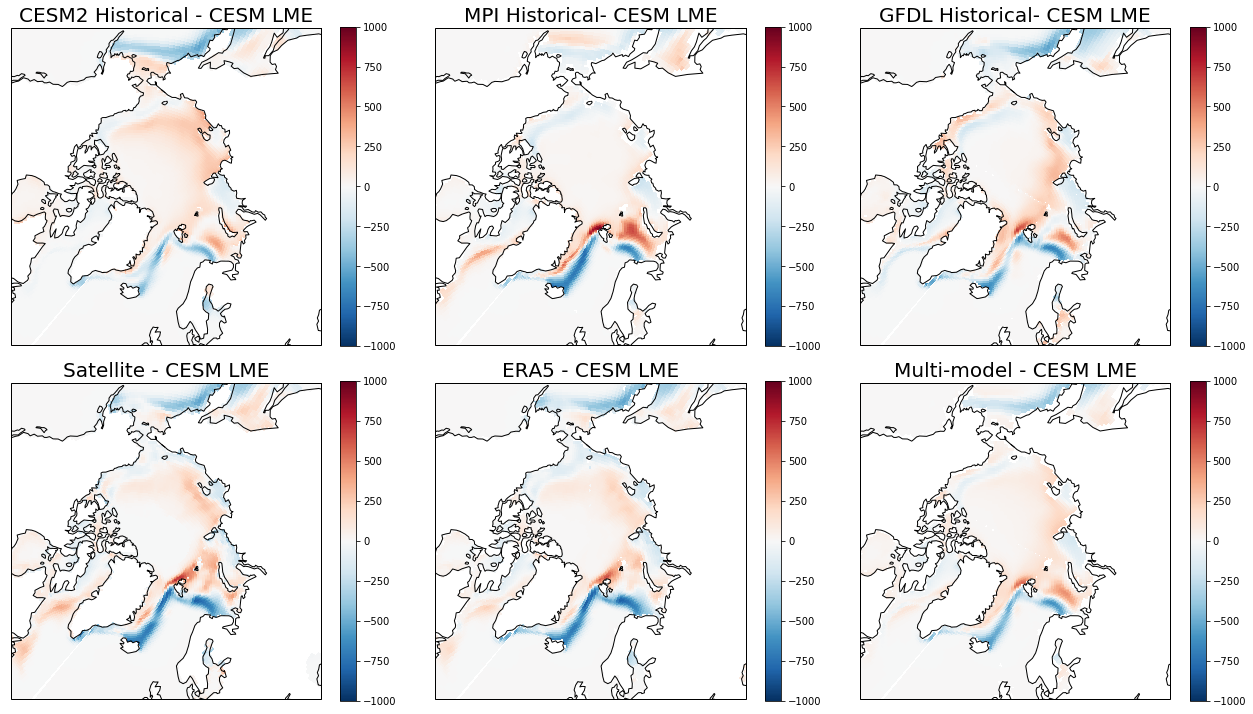

In [232]:
mnstates = [cesm2_hist_mnstate-train_mnstate, mpi_hist_mnstate-train_mnstate, gfdl_hist_mnstate-train_mnstate, 
            sat_mnstate-train_mnstate, era5_mnstate-train_mnstate, multimod_hist_mnstate-train_mnstate]
mnstate_titles = ['CESM2 Historical - CESM LME', 'MPI Historical- CESM LME', 'GFDL Historical- CESM LME', 
                  'Satellite - CESM LME', 'ERA5 - CESM LME', 'Multi-model - CESM LME']

#fig,axs = plt.subplots(2,2, projection=ccrs.NorthPolarStereo())
fig,axs = plt.subplots(2,3,figsize=(18,10),subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax = axs.flatten()

for i in range(len(mnstates)):
    ax[i].coastlines()
    ax[i].set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
    im = ax[i].pcolormesh(var_dict_train_tos['tos']['lon'], var_dict_train_tos['tos']['lat'], 
                          mnstates[i], transform=ccrs.PlateCarree(), cmap='RdBu_r',vmin=-1000,vmax=1000)
    fig.colorbar(im, ax=ax[i])
    ax[i].set_title(mnstate_titles[i], fontsize=20)
    
plt.tight_layout()

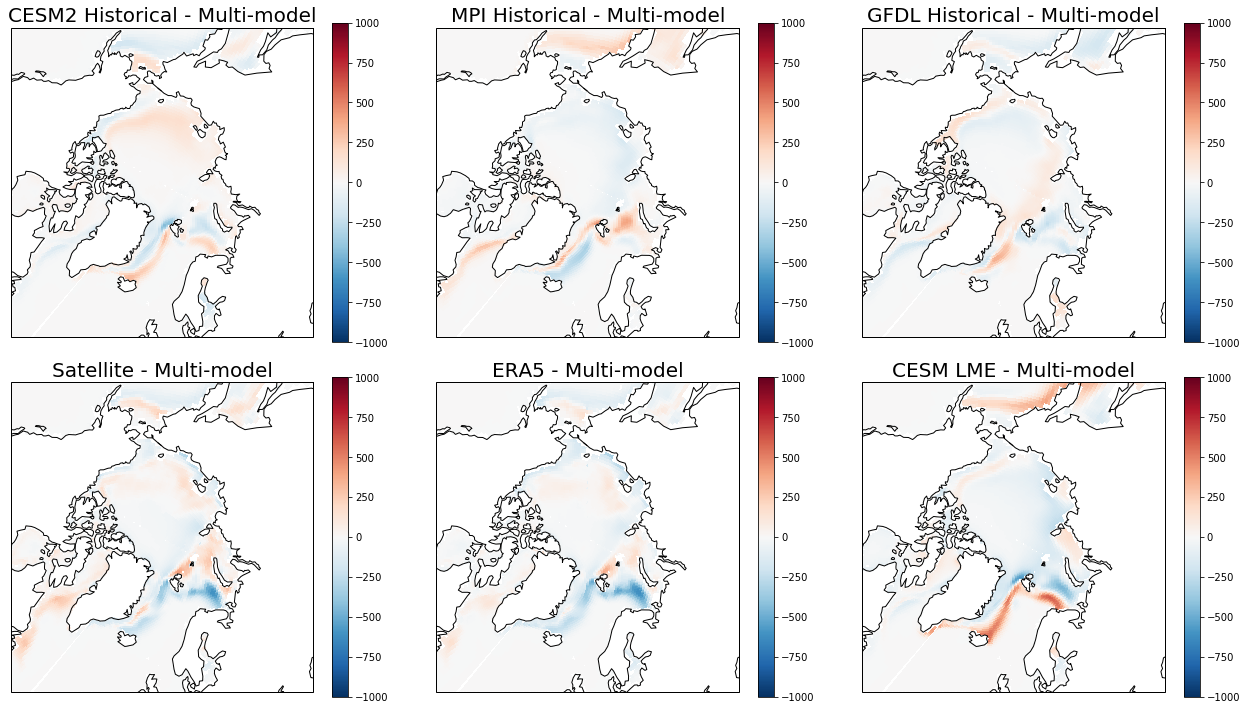

In [238]:
mnstates = [cesm2_hist_mnstate-multimod_hist_mnstate, mpi_hist_mnstate-multimod_hist_mnstate, gfdl_hist_mnstate-multimod_hist_mnstate,
            sat_mnstate-multimod_hist_mnstate, era5_mnstate-multimod_hist_mnstate, train_mnstate-multimod_hist_mnstate]
mnstate_titles = ['CESM2 Historical - Multi-model', 'MPI Historical - Multi-model', 'GFDL Historical - Multi-model', 
                  'Satellite - Multi-model', 'ERA5 - Multi-model', 'CESM LME - Multi-model']

#fig,axs = plt.subplots(2,2, projection=ccrs.NorthPolarStereo())
fig,axs = plt.subplots(2,3,figsize=(18,10),subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax = axs.flatten()

for i in range(len(mnstates)):
    ax[i].coastlines()
    ax[i].set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
    im = ax[i].pcolormesh(var_dict_train_tos['tos']['lon'], var_dict_train_tos['tos']['lat'], 
                          mnstates[i], transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=-1000,vmax=1000)
    fig.colorbar(im, ax=ax[i])
    ax[i].set_title(mnstate_titles[i], fontsize=20)
    
plt.tight_layout()

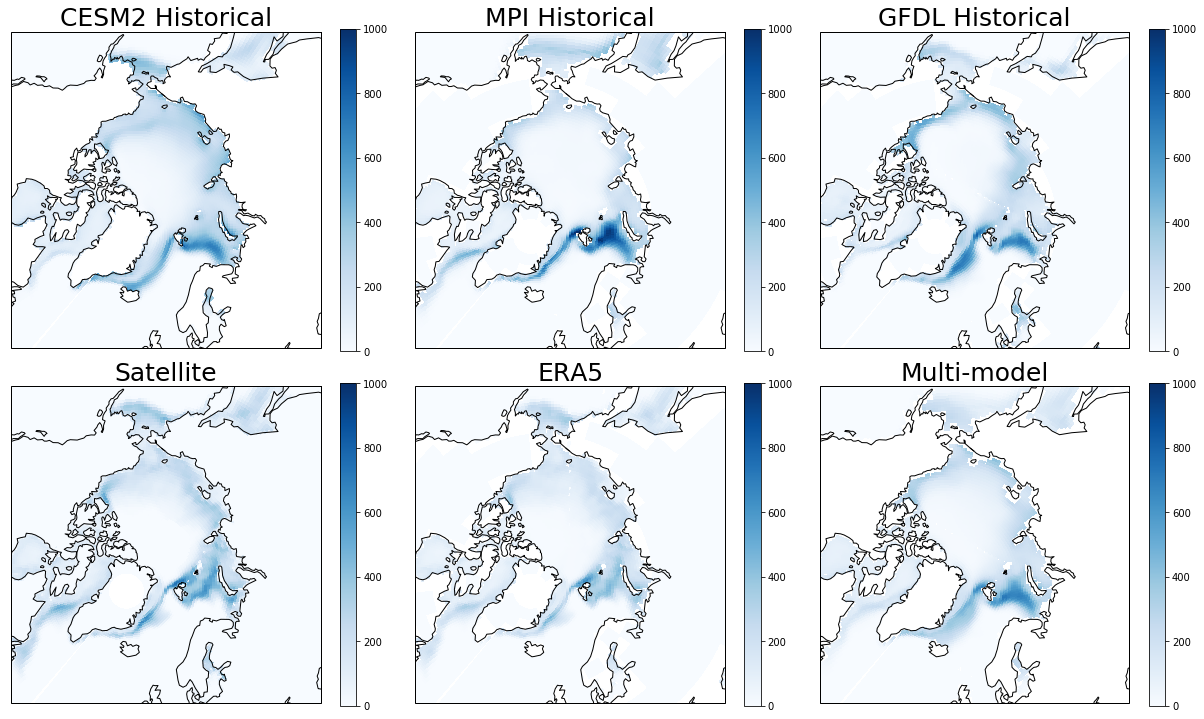

In [224]:
mnstates = [cesm2_hist_mnstate, mpi_hist_mnstate, gfdl_hist_mnstate, sat_mnstate, era5_mnstate, multimod_hist_mnstate]
mnstate_titles = ['CESM2 Historical', 'MPI Historical', 'GFDL Historical', 'Satellite', 'ERA5', 'Multi-model']

#fig,axs = plt.subplots(2,2, projection=ccrs.NorthPolarStereo())
fig,axs = plt.subplots(2,3,figsize=(17,10),subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax = axs.flatten()

for i in range(len(mnstates)):
    ax[i].coastlines()
    ax[i].set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
    im = ax[i].pcolormesh(var_dict_train_tos['tos']['lon'], var_dict_train_tos['tos']['lat'], 
                          mnstates[i], transform=ccrs.PlateCarree(), cmap='Blues', vmin=0, vmax=1000)
    fig.colorbar(im, ax=ax[i])
    ax[i].set_title(mnstate_titles[i], fontsize=25)
    
plt.tight_layout()

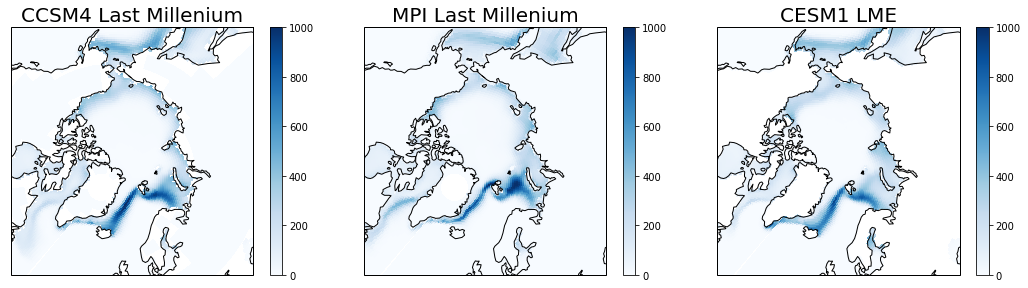

In [120]:
mnstates = [ccsm4_lm_mnstate, mpi_lm_mnstate, train_mnstate]
mnstate_titles = ['CCSM4 Last Millenium', 'MPI Last Millenium', 'CESM1 LME']

#fig,axs = plt.subplots(2,2, projection=ccrs.NorthPolarStereo())
fig,axs = plt.subplots(1,3,figsize=(15,4),subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax = axs.flatten()

for i in range(len(mnstates)):
    ax[i].coastlines()
    ax[i].set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
    im = ax[i].pcolormesh(var_dict_train_tos['tos']['lon'], var_dict_train_tos['tos']['lat'], 
                          mnstates[i], transform=ccrs.PlateCarree(), cmap='Blues', vmin=0, vmax=1000)
    fig.colorbar(im, ax=ax[i])
    ax[i].set_title(mnstate_titles[i], fontsize=20)
    
plt.tight_layout()

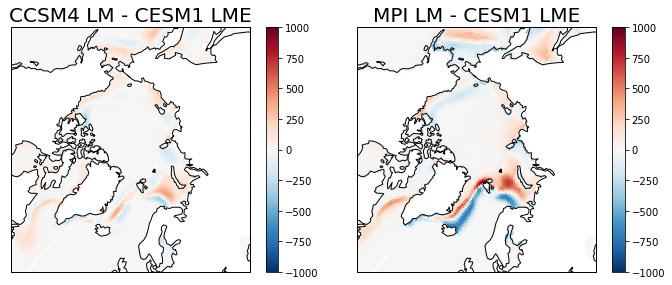

In [125]:
mnstates = [ccsm4_lm_mnstate - train_mnstate, mpi_lm_mnstate - train_mnstate]
mnstate_titles = ['CCSM4 LM - CESM1 LME', 'MPI LM - CESM1 LME']

#fig,axs = plt.subplots(2,2, projection=ccrs.NorthPolarStereo())
fig,axs = plt.subplots(1,2,figsize=(10,4),subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax = axs.flatten()

for i in range(len(mnstates)):
    ax[i].coastlines()
    ax[i].set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
    im = ax[i].pcolormesh(var_dict_train_tos['tos']['lon'], var_dict_train_tos['tos']['lat'], 
                          mnstates[i], transform=ccrs.PlateCarree(), cmap='RdBu_r',vmin=-1000,vmax=1000)
    fig.colorbar(im, ax=ax[i])
    ax[i].set_title(mnstate_titles[i], fontsize=20)
    
plt.tight_layout()

Text(0.5,1,'Variance: Satellite (1979-2016)')

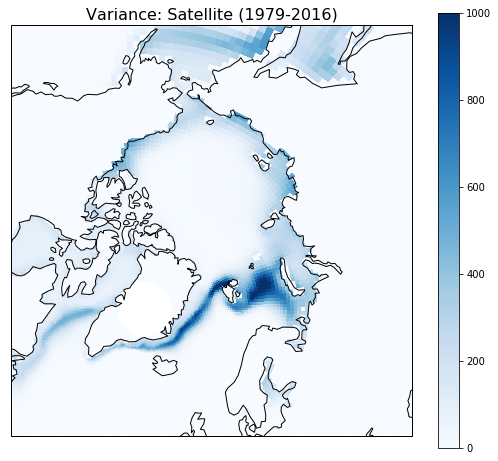

In [44]:
fig = plt.figure(1, figsize=(9, 8))
axs = plt.axes(projection=ccrs.NorthPolarStereo())
axs.coastlines()
axs.set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
im = axs.pcolormesh(var_dict_mpi_lm2['sic']['lon'], var_dict_mpi_lm2['sic']['lat'], 
                   mpi_lm_mnstate2, transform=ccrs.PlateCarree(), cmap='Blues', vmin=0,vmax=1000)
fig.colorbar(im)
plt.title('Variance: Satellite (1979-2016)', fontsize=16)

Text(0.5,1,'Variance: Satellite (1979-2016)')

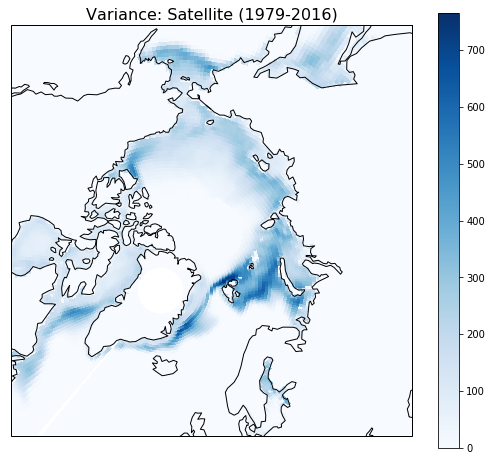

In [149]:
fig = plt.figure(1, figsize=(9, 8))
axs = plt.axes(projection=ccrs.NorthPolarStereo())
axs.coastlines()
axs.set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
im = axs.pcolormesh(var_dict_train_tos['tos']['lon'], var_dict_train_tos['tos']['lat'], 
              sat_mnstate, transform=ccrs.PlateCarree(), cmap='Blues')
fig.colorbar(im)
plt.title('Variance: Satellite (1979-2016)', fontsize=16)

Text(0.5,1,'Variance Difference: \nCESM LME (850-1650) - Satellite (1979-2016)')

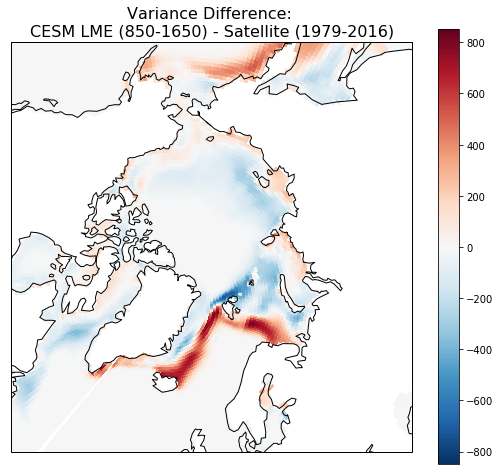

In [151]:
fig = plt.figure(1, figsize=(9, 8))
axs = plt.axes(projection=ccrs.NorthPolarStereo())
axs.coastlines()
axs.set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
im = axs.pcolormesh(var_dict_train_tos['tos']['lon'], var_dict_train_tos['tos']['lat'], 
                    (train_mnstate-sat_mnstate), transform=ccrs.PlateCarree(), cmap='RdBu_r',vmin=-850,vmax=850)
fig.colorbar(im)
plt.title('Variance Difference: \nCESM LME (850-1650) - Satellite (1979-2016)', fontsize=16)

Text(0.5,1,'Variance: CESM LME (850-1650)')

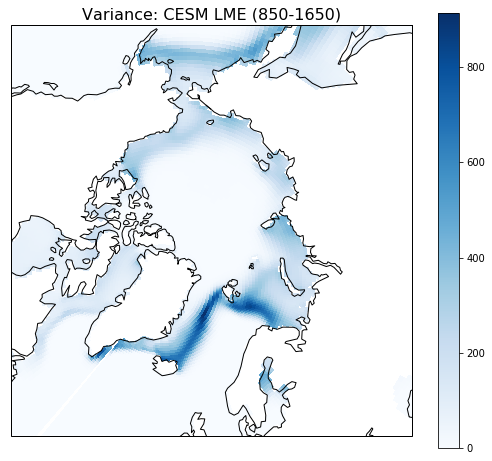

In [190]:
fig = plt.figure(1, figsize=(9, 8))
axs = plt.axes(projection=ccrs.NorthPolarStereo())
axs.coastlines()
axs.set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
im = axs.pcolormesh(var_dict_train_tos['tos']['lon'], var_dict_train_tos['tos']['lat'], 
              train_mnstate, transform=ccrs.PlateCarree(), cmap='Blues')
fig.colorbar(im)
plt.title('Variance: CESM LME (850-1650)', fontsize=16)

Text(0.5,1,'Variance: CESM LE (2007-2100)')

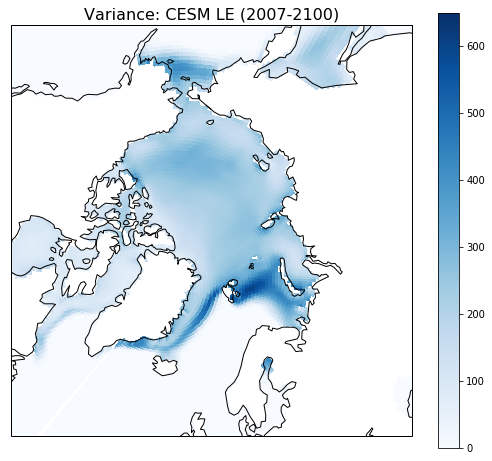

In [144]:
fig = plt.figure(1, figsize=(9, 8))
axs = plt.axes(projection=ccrs.NorthPolarStereo())
axs.coastlines()
axs.set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
im = axs.pcolormesh(var_dict_train_tos['tos']['lon'], var_dict_train_tos['tos']['lat'], 
                    le_mnstate, transform=ccrs.PlateCarree(), cmap='Blues')
fig.colorbar(im)
plt.title('Variance: CESM LE (2007-2100)', fontsize=16)

In [221]:
train_mnstate.flatten()

(30720,)

Text(0.5,1,'Variance Difference: \nCESM LME (850-1650) - CESM LE (2007-2057)')

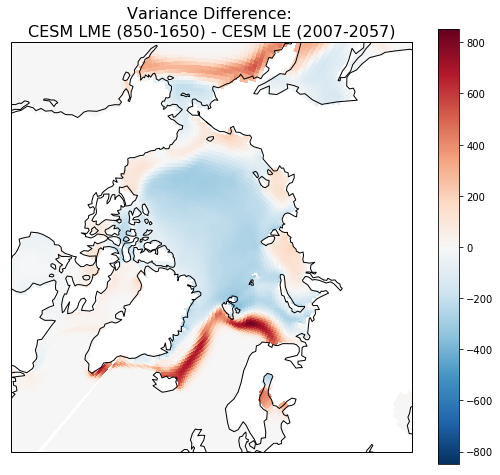

In [218]:
fig = plt.figure(1, figsize=(9, 8))
axs = plt.axes(projection=ccrs.NorthPolarStereo())
axs.coastlines()
axs.set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
im = axs.pcolormesh(var_dict_train_tos['tos']['lon'], var_dict_train_tos['tos']['lat'], 
                    (train_mnstate-le_mnstate), transform=ccrs.PlateCarree(), cmap='RdBu_r',vmin=-850,vmax=850)
fig.colorbar(im)
plt.title('Variance Difference: \nCESM LME (850-1650) - CESM LE (2007-2057)', fontsize=16)

In [224]:
scor_train_le = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),np.nan_to_num(le_mnstate.flatten()))[0,1]
scor_train_le

0.48215519742634216

Text(0.5,1,'Variance: CESM LME (1850-2005)')

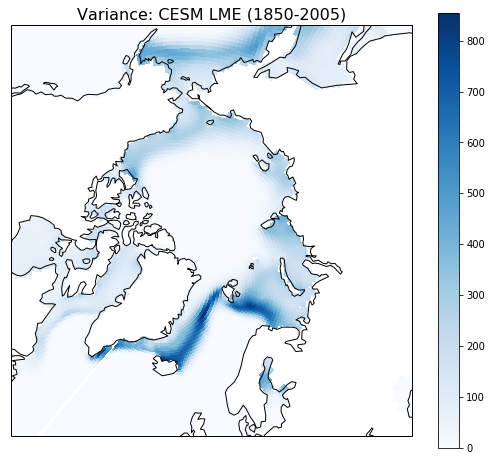

In [188]:
fig = plt.figure(1, figsize=(9, 8))
axs = plt.axes(projection=ccrs.NorthPolarStereo())
axs.coastlines()
axs.set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
im = axs.pcolormesh(var_dict_train_tos['tos']['lon'], var_dict_train_tos['tos']['lat'], 
                    lme_mnstate, transform=ccrs.PlateCarree(), cmap='Blues')
fig.colorbar(im)
plt.title('Variance: CESM LME (1850-2005)', fontsize=16)

In [225]:
scor_train_lme = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),np.nan_to_num(lme_mnstate.flatten()))[0,1]
scor_train_lme

0.9886389099677787

Text(0.5,1,'Variance Difference: \nCESM LME (850-1650) - CESM LME (1850-2005')

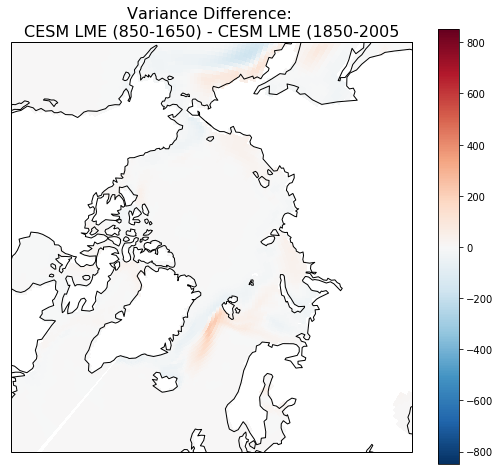

In [193]:
fig = plt.figure(1, figsize=(9, 8))
axs = plt.axes(projection=ccrs.NorthPolarStereo())
axs.coastlines()
axs.set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
im = axs.pcolormesh(var_dict_train_tos['tos']['lon'], var_dict_train_tos['tos']['lat'], 
                    (train_mnstate-lme_mnstate), transform=ccrs.PlateCarree(), cmap='RdBu_r',vmin=-850,vmax=850)
fig.colorbar(im)
plt.title('Variance Difference: \nCESM LME (850-1650) - CESM LME (1850-2005)', fontsize=16)

Text(0.5,1,'Variance: ERA5 (1980-2020)')

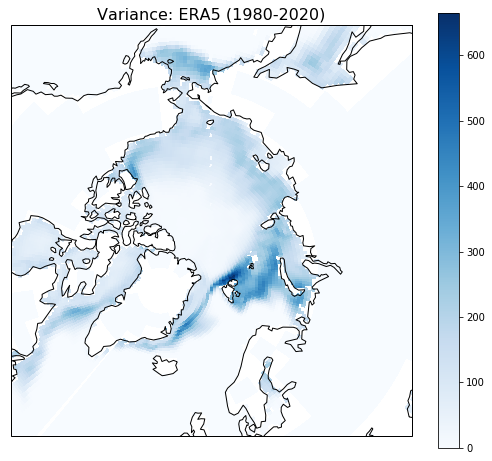

In [215]:
fig = plt.figure(1, figsize=(9, 8))
axs = plt.axes(projection=ccrs.NorthPolarStereo())
axs.coastlines()
axs.set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
im = axs.pcolormesh(var_dict_train_tos['tos']['lon'], var_dict_train_tos['tos']['lat'],
                    era5_mnstate, transform=ccrs.PlateCarree(), cmap='Blues')
fig.colorbar(im)
plt.title('Variance: ERA5 (1980-2020)', fontsize=16)

Text(0.5,1,'Variance Difference: \nCESM LME (850-1650) - Variance: ERA5 (1980-2020)')

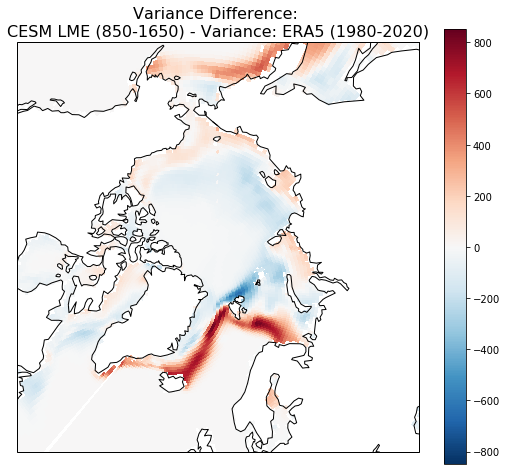

In [216]:
fig = plt.figure(1, figsize=(9, 8))
axs = plt.axes(projection=ccrs.NorthPolarStereo())
axs.coastlines()
axs.set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
im = axs.pcolormesh(var_dict_train_tos['tos']['lon'], var_dict_train_tos['tos']['lat'], 
                    (train_mnstate-era5_mnstate), transform=ccrs.PlateCarree(), cmap='RdBu_r',vmin=-850,vmax=850)
fig.colorbar(im)
plt.title('Variance Difference: \nCESM LME (850-1650) - Variance: ERA5 (1980-2020)', fontsize=16)

In [226]:
scor_train_era5 = np.corrcoef(np.nan_to_num(train_mnstate.flatten()),np.nan_to_num(era5_mnstate.flatten()))[0,1]
scor_train_era5

0.4622404964005686

NameError: name 'scor_train_lme' is not defined